Today, you started working in the Bank. Your manager take you to a meeting about a new commercial product of Bank. In this meeting, Mr. Yıldız, the Marketing Manager of the Commercial segment, stated that “Bank is one of the leading banks and we developed a new product for commercial clients. We have been working for months. As a result of the studies, we believe that clients with over 5 million TL annual net sales are the most suitable to offer this new product.”

He also added:  “As you know, banks do not have current financial statement of each company. Without financial statements, we cannot get proper net sales information of customers. We can already reach suitable clients for the new product for those with current financials available in our databases. However, we want to be sure that we reach all targeted customers. So, we have to find a way to decide which one of these clients without financials have actually over 5 million TL net sales.”

Then, the Commercial Loan Allocation Manager stated that total risk and total limit amounts in the banking sector can be reached for Bank clients and this information could be used for estimation.

Mr. Yıldız asked, “If the clients has more than 5 million TL total loan balance in banking sector, may  their net sales be higher than 5 million TL too?”

Commercial Loan Allocation Manager Mrs. İlhan replied “Even though there are exceptions, generally it is correct. In addition, companies with more experience and having institutional culture are generally in the leading position in the sector. Therefore, they should be evaluated."

Your manager took the floor and introduced you to other managers. “We can develop the most suitable model by looking at the data” he said, adding that you can develop a model that would solve this problem. In the end, by adding “with data we can create the most appropriate solution.”

After meeting, you take related information from databases. The following information could be reached through the queries in the databases. Information are shown as empty (NULL) if no data is available.

* YEAR	Date of data
* Customer_num	Customer identification number
* Establishment_Date	Company establishment date
* Number_of_Emp	Number of employees
* Profit	Annual profit
* Sector	Sector that company operates
* Region	Geographic region
* Total Risk 	Total loan balance amount in the banking sector
* Total Limit	Total limit in the banking sector
* Sales	0 if Sales =< 5 million TL
* 1 if Sales > 5 million TL
* 3 if Sales is not available.

In [1]:
# Required Library and Functions

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold, cross_val_score, StratifiedShuffleSplit,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import datetime as dt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
pd.set_option('display.max_rows', None)

# To Turn Off Warnings
import warnings

warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

REQUIRED FUNCTIONS

In [2]:
############################################
# Eda Analysis
############################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
############################################
# Outlier
############################################

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##############################################
# cat_cols, num_cols, cat_but_car, num_but_cat
###############################################

# All categorical, numeric and other variables in the data are checked.
def grab_col_names(dataframe, cat_th=10, car_th=20):

# cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat
###############################################
# one_hot_encoder
###############################################

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
#############################################
# rare_analyser
#############################################

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts())) # Sınıf Sayısı
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
##############################################
# rare_encoder
#############################################

def rare_encoder(dataframe, rare_perc, cat_cols):
    temp_df = dataframe.copy()
    rare_columns = [col for col in cat_cols if (temp_df[col].value_counts() / len(temp_df) < rare_perc).sum() > 1]

    for col in rare_columns:
        tmp = temp_df[col].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[col] = np.where(temp_df[col].isin(rare_labels), 'Rare', temp_df[col])

    return temp_df
#############################################
# cat_summary
#############################################
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
###############################################
# num_summary
#############################################
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        
##############################################
# target_summary_with_num
###############################################
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    

In [3]:
###########################################
# READING THE DATA
###########################################
dfilk = pd.read_csv("../input/final1/Data_Set_Final_Project.csv")

dfilk.head(10)

,YEAR,Customer_num,Establishment_Date,Number_of_Emp,Profit,Sector,Region,Total_Risk,Total_Limit,Sales
0,2017,RATI9590GZD,26.01.2001,8.000,NaN,RETAIL-WHOLESALE,Marmara Region,70917.000,7000007.000,3
1,2015,RATI2539VHR,24.02.1994,21.000,32615.000,MANUFACTURING,Central Anatolia Region,682602.000,2354029.000,0
2,2010,RATI4481GNN,25.01.1996,7.000,282834.000,RETAIL-WHOLESALE,Mediterranean Region,115581.000,592922.000,0
3,2012,RATI4948THA,7.04.2004,34.000,35597.000,MANUFACTURING,Southeastern Anatolia Region,39334.000,2471021.000,1
4,2013,RATI8841WYZ,24.04.2006,15.000,134259.000,SERVICES,Aegean Region,71295.000,506238.000,0
5,2011,RATI6581GZV,27.01.2007,25.000,NaN,OTHERS,Marmara Region,524053.000,1225401.000,3
6,2017,RATI9051OKI,16.06.2000,8.000,6481.000,MANUFACTURING,Marmara Region,107145.000,873191.000,0
7,2012,RATI8817WSE,24.03.1998,13.000,NaN,MANUFACTURING,Eastern Anatolia Region,299797.000,701336.000,3
8,2014,RATI8420EUQ,8.11.2009,3.000,45293.000,MANUFACTURING,Mediterranean Region,1513099.000,2291052.000,0
9,2012,RATI7366ECM,18.12.2005,21.000,7825.000,RETAIL-WHOLESALE,Central Anatolia Region,355087.000,1512329.000,1


# EDA

In [4]:
dfilk.shape

(11357, 10)

We subtract the ones with sales of 3 from the data.Because their sales information is 0,
these data will not be of use to us.

In [5]:
dfilk_3 = dfilk[dfilk['Sales'] == 3]
dfilk = dfilk[~(dfilk['Sales'] == 3)]

In [6]:
# let's look at shape again
dfilk.shape

(8526, 10)

In [7]:
# Let's look at the columns of data.
dfilk.columns

Index(['YEAR', 'Customer_num', 'Establishment_Date', 'Number_of_Emp', 'Profit', 'Sector', 'Region', 'Total_Risk', 'Total_Limit', 'Sales'], dtype='object')

In [8]:
# Converts from Establishment Date object to date format.
dfilk['Establishment_Date'] = pd.to_datetime(dfilk['Establishment_Date'])

In [9]:
# Let's examine our data in general.
check_df(dfilk)

##################### Shape #####################
(8526, 10)
##################### Types #####################
YEAR                           int64
Customer_num                  object
Establishment_Date    datetime64[ns]
Number_of_Emp                float64
Profit                       float64
Sector                        object
Region                        object
Total_Risk                   float64
Total_Limit                  float64
Sales                          int64
dtype: object
##################### Head #####################
   YEAR Customer_num Establishment_Date  Number_of_Emp     Profit            Sector                        Region  Total_Risk  Total_Limit  Sales
1  2015  RATI2539VHR         1994-02-24         21.000  32615.000     MANUFACTURING       Central Anatolia Region  682602.000  2354029.000      0
2  2010  RATI4481GNN         1996-01-25          7.000 282834.000  RETAIL-WHOLESALE          Mediterranean Region  115581.000   592922.000      0
3  2012  RATI4948T

In [10]:
# Let's determine the categorical and numeric columns.
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dfilk)

Observations: 8526
Variables: 10
cat_cols: 4
num_cols: 5
cat_but_car: 1
num_but_cat: 2


In [11]:
# Let's look at the ratios according to the dependent variable
rare_analyser(dfilk,'Sales',cat_cols)

Sector : 4
                  COUNT  RATIO  TARGET_MEAN
MANUFACTURING      2229  0.261        0.188
OTHERS             1366  0.160        0.129
RETAIL-WHOLESALE   4230  0.496        0.179
SERVICES            701  0.082        0.128


Region : 7
                              COUNT  RATIO  TARGET_MEAN
Aegean Region                   922  0.108        0.154
Black Sea Region                343  0.040        0.169
Central Anatolia Region        1167  0.137        0.189
Eastern Anatolia Region         146  0.017        0.144
Marmara Region                 3823  0.448        0.174
Mediterranean Region            849  0.100        0.146
Southeastern Anatolia Region    304  0.036        0.171


YEAR : 8
      COUNT  RATIO  TARGET_MEAN
2010    639  0.075        0.197
2011    850  0.100        0.164
2012    987  0.116        0.176
2013   1019  0.120        0.170
2014   1136  0.133        0.171
2015   1209  0.142        0.161
2016   1333  0.156        0.167
2017   1353  0.159        0.161


Sales :

In [12]:
# Let's do outlier analysis.
for col in num_cols:
    print(col, check_outlier(dfilk, col))

Establishment_Date True
Number_of_Emp True
Profit True
Total_Risk True
Total_Limit True


In [13]:
# Let's look at the outliers of numeric columns graphically.

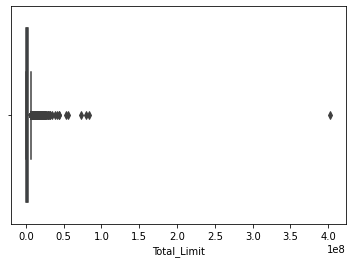

In [14]:
sns.boxplot(dfilk['Total_Limit'])
plt.show()

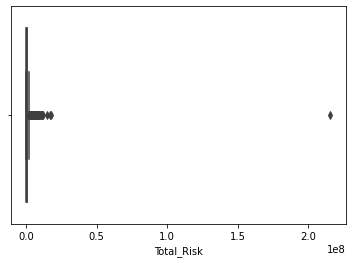

In [15]:
sns.boxplot(dfilk['Total_Risk'])
plt.show()

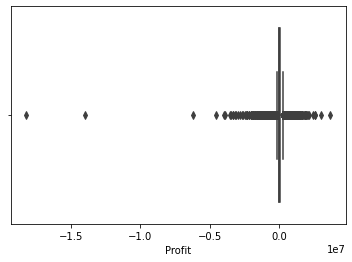

In [16]:
sns.boxplot(dfilk['Profit'])
plt.show()

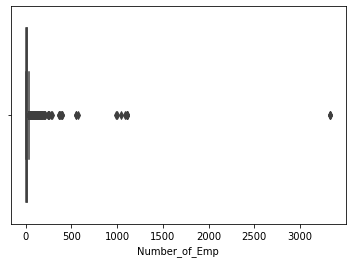

In [17]:
sns.boxplot(dfilk['Number_of_Emp'])
plt.show()

In [18]:
# Let's see Describe
dfilk.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,8526.000,2013.981,2.208,2010.000,2012.000,2014.000,2016.000,2017.000
Number_of_Emp,8135.000,16.297,77.654,1.000,4.000,8.000,16.000,3333.000
Profit,8526.000,61383.427,408409.023,-18284524.000,13497.250,45052.500,116589.750,3724579.000
Total_Risk,8433.000,897268.432,2631801.492,0.000,156447.000,453724.000,1094305.000,215495035.000
Total_Limit,8433.000,2488763.672,5577535.906,2972.000,594056.000,1403481.000,3137171.000,402724973.000
Sales,8526.000,0.169,0.375,0.000,0.000,0.000,0.000,1.000


In [19]:
# Let's look at categorical variable summaries.

                  Sector  Ratio
RETAIL-WHOLESALE    4230 49.613
MANUFACTURING       2229 26.144
OTHERS              1366 16.022
SERVICES             701  8.222
##########################################


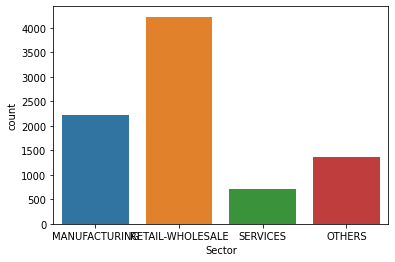

In [20]:
cat_summary(dfilk, "Sector", plot=True)

   Sales  Ratio
0   7084 83.087
1   1442 16.913
##########################################


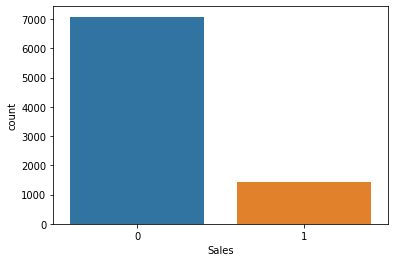

In [21]:
cat_summary(dfilk, "Sales", plot=True)

                              Region  Ratio
Marmara Region                  3823 44.839
Central Anatolia Region         1167 13.688
Aegean Region                    922 10.814
Mediterranean Region             849  9.958
Black Sea Region                 343  4.023
Southeastern Anatolia Region     304  3.566
Eastern Anatolia Region          146  1.712
##########################################


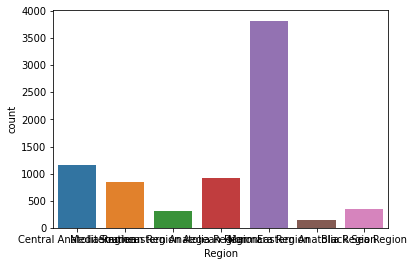

In [22]:
cat_summary(dfilk, "Region", plot=True)

count                    8526
unique                   5130
top       1997-10-01 00:00:00
freq                       10
first     1900-01-18 00:00:00
last      2016-06-14 00:00:00
Name: Establishment_Date, dtype: object


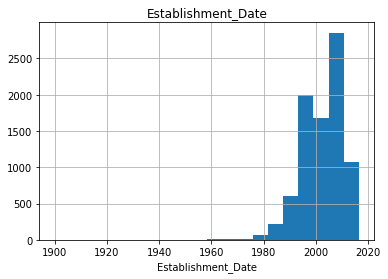

count   8135.000
mean      16.297
std       77.654
min        1.000
5%         1.000
10%        2.000
20%        3.000
30%        5.000
40%        5.000
50%        8.000
60%       10.000
70%       14.000
80%       19.000
90%       30.000
95%       42.000
99%      114.000
max     3333.000
Name: Number_of_Emp, dtype: float64


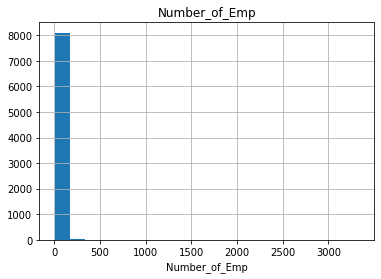

count        8526.000
mean        61383.427
std        408409.023
min     -18284524.000
5%        -249712.500
10%        -69049.500
20%          7826.000
30%         18863.000
40%         30151.000
50%         45052.500
60%         65073.000
70%         92647.000
80%        147649.000
90%        272038.500
95%        454758.250
99%       1082108.000
max       3724579.000
Name: Profit, dtype: float64


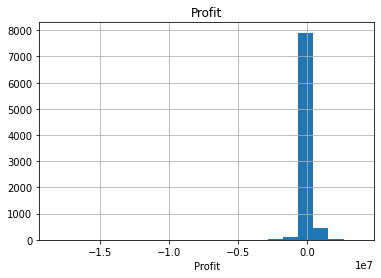

count        8433.000
mean       897268.432
std       2631801.492
min             0.000
5%          23303.600
10%         48125.200
20%        114515.600
30%        198496.000
40%        309222.600
50%        453724.000
60%        647123.200
70%        905516.200
80%       1354170.600
90%       2196601.000
95%       3093680.800
99%       5783090.040
max     215495035.000
Name: Total_Risk, dtype: float64


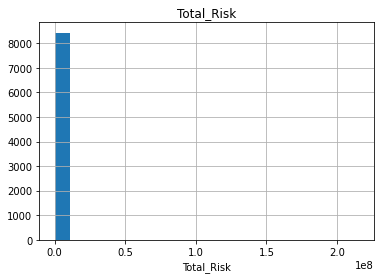

count        8433.000
mean      2488763.672
std       5577535.906
min          2972.000
5%         134303.400
10%        235685.000
20%        462090.400
30%        731760.000
40%       1017480.000
50%       1403481.000
60%       1907823.400
70%       2632166.000
80%       3698375.800
90%       5540732.600
95%       7846665.800
99%      14799653.680
max     402724973.000
Name: Total_Limit, dtype: float64


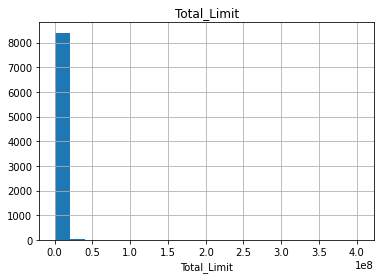

In [23]:
# Let's look at numeric variable summaries
for col in num_cols:
    num_summary(dfilk, col, plot=True)

In [24]:
# We will see if we can establish a similarity with companies with an old foundation year and sales of more
# than 5 million TL.
# We brought the ones with sales of 1 (those over 5 million TL).
dfilk_1 = dfilk[dfilk['Sales']==1]
dfilk_1=dfilk_1.sort_values('Number_of_Emp',ascending=False)
# We looked at the years of establishment of those with 1 sales, and thus whether they are well-established
# establishments.
dfilk_1.groupby(['Establishment_Date','Number_of_Emp'])['Sales'].count().head(20)

Establishment_Date  Number_of_Emp
1954-04-11          15.000           1
1954-11-23          14.000           1
1954-11-30          15.000           1
1966-03-04          7.000            1
1966-05-04          10.000           1
1975-08-30          74.000           1
1978-01-13          1.000            1
1978-01-22          18.000           1
1978-02-13          24.000           1
                    26.000           1
1978-03-10          89.000           1
1978-06-16          6.000            1
1978-06-18          6.000            1
1978-11-06          6.000            1
1978-12-04          21.000           1
1979-01-25          22.000           1
1979-02-28          21.000           1
1979-03-14          20.000           1
1979-11-01          22.000           1
1980-08-19          26.000           1
Name: Sales, dtype: int64

In [25]:
# We will see if we can establish a similarity with companies with an old establishment year
# and sales of more than 5 million TL.
# We brought the ones with 1 sales (over 5 million TL).
dfilk_0 = dfilk[dfilk['Sales'] == 0]
dfilk_1 = dfilk_1.sort_values('Number_of_Emp', ascending=False)
# We looked at the years of establishment of those with 1 sales, and thus whether they are well-established
# establishments.
dfilk_0.groupby(['Establishment_Date','Number_of_Emp'])['Sales'].count().head(20)

Establishment_Date  Number_of_Emp
1900-01-18          2.000            1
1955-04-28          5.000            1
1955-08-05          5.000            1
1960-04-06          10.000           1
1960-05-27          10.000           1
1960-05-30          10.000           1
1960-06-15          10.000           1
1960-06-25          10.000           1
1960-07-06          1.000            1
1965-02-08          62.000           1
1965-03-08          22.000           1
1965-05-08          18.000           1
1965-07-18          16.000           1
1965-07-30          59.000           1
1965-08-16          18.000           1
1965-12-08          18.000           1
1966-04-16          10.000           1
1966-09-04          10.000           1
1966-12-04          10.000           1
1967-07-09          52.000           1
Name: Sales, dtype: int64

In [26]:
# Let's look at the Region names
dfilk['Region'].unique()

array(['Central Anatolia Region', 'Mediterranean Region',
       'Southeastern Anatolia Region', 'Aegean Region', 'Marmara Region',
       nan, 'Eastern Anatolia Region', 'Black Sea Region'], dtype=object)

In [27]:
# Let's look at the numeric columns according to Sales.
for col in num_cols:
    target_summary_with_num(dfilk, "Sales", col)

                 Establishment_Date
Sales                              
0     2002-08-25 04:59:25.443252352
1     2001-02-01 11:58:00.166435456


       Number_of_Emp
Sales               
0             14.393
1             25.736


          Profit
Sales           
0      45051.239
1     141617.284


       Total_Risk
Sales            
0      785777.136
1     1441887.462


       Total_Limit
Sales             
0      2121522.090
1      4282686.261




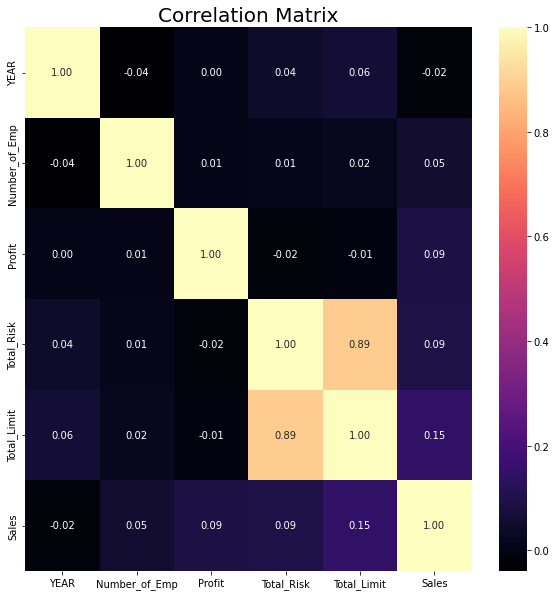

In [28]:
# Let's look at the correlations.
dfilk.corr()
f, ax = plt.subplots(figsize=[10, 10])
sns.heatmap(dfilk.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [29]:
###########################################
# READING THE DATA
###########################################
# NOTE: Since we have created some variables in excel, we are reading the edited data again.
df = pd.read_csv("../input/final2/Final_Project.csv")
df.head()

,YEAR,Customer_num,Establishment_Date,Number_of_Emp,Profit,Sector,Region,Total_Risk,Total_Limit,Sales,cus_tenure,last_credit_time,number_of_transactions
0,2017,RATI9590GZD,26.01.2001,8.000,NaN,RETAIL-WHOLESALE,Marmara Region,70917.000,7000007.000,3,8,1,3
1,2015,RATI2539VHR,24.02.1994,21.000,32615.000,MANUFACTURING,Central Anatolia Region,682602.000,2354029.000,0,5,1,5
2,2010,RATI4481GNN,25.01.1996,7.000,282834.000,RETAIL-WHOLESALE,Mediterranean Region,115581.000,592922.000,0,8,6,3
3,2012,RATI4948THA,7.04.2004,34.000,35597.000,MANUFACTURING,Southeastern Anatolia Region,39334.000,2471021.000,1,6,6,1
4,2013,RATI8841WYZ,24.04.2006,15.000,134259.000,SERVICES,Aegean Region,71295.000,506238.000,0,6,5,2


# **DATA PREPERATION**

In [30]:
###########################################
# DATA_PREP
###########################################

def data_prep(dataframe):
    # Establishment_Date object. We convert it to date format.
    dataframe['Establishment_Date'] = pd.to_datetime(dataframe['Establishment_Date'])
    check_df(dataframe)
    df_3 = dataframe[dataframe['Sales'] == 3]

    df = dataframe[~(dataframe['Sales'] == 3)]

    check_df(df)
    return df, df_3



In [31]:
df, df_3 = data_prep(df)
df.head()

##################### Shape #####################
(11357, 13)
##################### Types #####################
YEAR                               int64
Customer_num                      object
Establishment_Date        datetime64[ns]
Number_of_Emp                    float64
Profit                           float64
Sector                            object
Region                            object
Total_Risk                       float64
Total_Limit                      float64
Sales                              int64
cus_tenure                         int64
last_credit_time                   int64
number_of_transactions             int64
dtype: object
##################### Head #####################
   YEAR Customer_num Establishment_Date  Number_of_Emp     Profit            Sector                        Region  Total_Risk  Total_Limit  Sales  cus_tenure  \
0  2017  RATI9590GZD         2001-01-26          8.000        NaN  RETAIL-WHOLESALE                Marmara Region   70917.000  7000

,YEAR,Customer_num,Establishment_Date,Number_of_Emp,Profit,Sector,Region,Total_Risk,Total_Limit,Sales,cus_tenure,last_credit_time,number_of_transactions
1,2015,RATI2539VHR,1994-02-24,21.000,32615.000,MANUFACTURING,Central Anatolia Region,682602.000,2354029.000,0,5,1,5
2,2010,RATI4481GNN,1996-01-25,7.000,282834.000,RETAIL-WHOLESALE,Mediterranean Region,115581.000,592922.000,0,8,6,3
3,2012,RATI4948THA,2004-07-04,34.000,35597.000,MANUFACTURING,Southeastern Anatolia Region,39334.000,2471021.000,1,6,6,1
4,2013,RATI8841WYZ,2006-04-24,15.000,134259.000,SERVICES,Aegean Region,71295.000,506238.000,0,6,5,2
6,2017,RATI9051OKI,2000-06-16,8.000,6481.000,MANUFACTURING,Marmara Region,107145.000,873191.000,0,3,1,2


In [32]:
df_3.head()

,YEAR,Customer_num,Establishment_Date,Number_of_Emp,Profit,Sector,Region,Total_Risk,Total_Limit,Sales,cus_tenure,last_credit_time,number_of_transactions
0,2017,RATI9590GZD,2001-01-26,8.000,NaN,RETAIL-WHOLESALE,Marmara Region,70917.000,7000007.000,3,8,1,3
5,2011,RATI6581GZV,2007-01-27,25.000,NaN,OTHERS,Marmara Region,524053.000,1225401.000,3,8,5,3
7,2012,RATI8817WSE,1998-03-24,13.000,NaN,MANUFACTURING,Eastern Anatolia Region,299797.000,701336.000,3,6,1,5
12,2015,RATI7536QZP,2007-12-17,5.000,NaN,RETAIL-WHOLESALE,Marmara Region,2895474.000,7150547.000,3,4,3,2
14,2010,RATI4596AHS,1992-01-28,NaN,NaN,MANUFACTURING,Marmara Region,762480.000,2252312.000,3,8,1,4


In [33]:
###########################################
# FILLING MISSING VALUES
###########################################

def missing_value(dataframe):
    dataframe["Total_Risk"] = dataframe["Total_Risk"].fillna(dataframe.groupby("Sales")["Total_Risk"].transform("median"))
    dataframe["Total_Limit"] = dataframe["Total_Limit"].fillna(dataframe.groupby("Sales")["Total_Limit"].transform("median"))
    dataframe["Number_of_Emp"] = dataframe["Number_of_Emp"].fillna(dataframe.groupby("Sales")["Number_of_Emp"].transform("median"))
    dataframe = dataframe.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
    check_df(dataframe)
    return dataframe

In [34]:
df = missing_value(df)
check_df(df)

##################### Shape #####################
(8526, 13)
##################### Types #####################
YEAR                               int64
Customer_num                      object
Establishment_Date        datetime64[ns]
Number_of_Emp                    float64
Profit                           float64
Sector                            object
Region                            object
Total_Risk                       float64
Total_Limit                      float64
Sales                              int64
cus_tenure                         int64
last_credit_time                   int64
number_of_transactions             int64
dtype: object
##################### Head #####################
   YEAR Customer_num Establishment_Date  Number_of_Emp     Profit            Sector                        Region  Total_Risk  Total_Limit  Sales  cus_tenure  \
1  2015  RATI2539VHR         1994-02-24         21.000  32615.000     MANUFACTURING       Central Anatolia Region  682602.000  23540

# **FEATURE ENGINEERING**

In [35]:
###########################################
# FEATURE ENGINEERING
###########################################

def feature_engineering(dataframe):

    #TOTAL_RISK
    a = dataframe.groupby('Customer_num')['Total_Risk'].sum()
    a = a.reset_index()
    a.rename(columns={'Total_Risk': 'sum_of_risk'}, inplace=True)
    dataframe = dataframe.merge(a, 'outer')

    # TOTAL_LIMIT
    b = dataframe.groupby('Customer_num')['Total_Limit'].sum()
    b = b.reset_index()
    b.rename(columns={'Total_Limit': 'sum_of_limit'}, inplace=True)
    dataframe = dataframe.merge(b, 'outer')

    # TOTAL_PROFIT
    c = dataframe.groupby('Customer_num')['Profit'].sum()
    c = c.reset_index()
    c.rename(columns={'Profit': 'sum_of_profit'}, inplace=True)
    dataframe = dataframe.merge(c, 'outer')

    #YEAR
    current_year = dataframe['YEAR'].max() + 1

    dataframe['year_tenure'] = current_year - dataframe['YEAR']
    current_date = pd.to_datetime('2017-12-31 0:0:0')  # analysis date is determined.
    dataframe["days"] = (current_date - dataframe['Establishment_Date']).dt.days
    dataframe['Establishment_Tenure'] = dataframe["days"] / 365
    dataframe['TEtablisement+Nemployeur'] = dataframe['Establishment_Tenure'] + dataframe['Number_of_Emp']
    dataframe['TEtablisement*Nemployeur'] = dataframe['Establishment_Tenure'] * dataframe['Number_of_Emp']
    dataframe['total_risk_rate'] = dataframe['Total_Risk'] / dataframe['Total_Limit']
    dataframe['tyear+testablisment+nempl'] = dataframe['cus_tenure'] + dataframe['Establishment_Tenure'] + dataframe['Number_of_Emp']
    dataframe['tyear*testablisment*nempl'] = dataframe['cus_tenure'] * dataframe['Establishment_Tenure'] * dataframe['Number_of_Emp']
    dataframe['New_Establishment_Tenure'] = pd.cut(dataframe['Establishment_Tenure'], bins=[0, 10, 14, 20, 40, 60, 119],
                                            labels=['0-10', '11-14', '15-20', '21-40', '41-60', '61-119'])
    dataframe = dataframe.drop(['YEAR', 'Establishment_Date', "days"], axis=1)

    #NUM_OF_EMPLOYEE
    dataframe['Cat_Number_of_Emp'] = pd.cut(dataframe['Number_of_Emp'], bins=[0, 4, 7, 15, 200, 3333],
                                     labels=['0_4', '5_7', '8-15', '16-200', '201-3333'])

    # PROFIT
    bins = [dataframe['Profit'].min() - 1, 46000, 460000, 1100000, dataframe['Profit'].max()]
    labels = ['VERY_SMALL', 'SMALL', 'MIDDLE', 'HIGH']
    dataframe['NEW_PROFIT'] = pd.cut(dataframe['Profit'], bins, labels=labels).astype(str)

    # AGE_CATEGORY
    bins = [dataframe['cus_tenure'].min() - 1, 4, 6, dataframe['cus_tenure'].max()]
    labels = ['YOUNG', 'MIDDLE', 'MATURE']
    dataframe['NEW_YEAR_TENURE'] = pd.cut(dataframe['cus_tenure'], bins, labels=labels).astype(str)

    # YEAR_PROFIT
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & ((dataframe['NEW_PROFIT'] == 'VERY_SMALL') | (
            dataframe['NEW_PROFIT'] == 'SMALL')), 'NEW_YEAR_PROFIT'] = 'YOUNG_SMALL_PROFIT'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
                dataframe['NEW_PROFIT'] == 'MIDDLE'), 'NEW_YEAR_PROFIT'] = 'YOUNG_LOW_PROFIT'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
                dataframe['NEW_PROFIT'] == 'HIGH'), 'NEW_YEAR_PROFIT'] = 'YOUNG_LOW_PROFIT'

    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & ((dataframe['NEW_PROFIT'] == 'VERY_SMALL') | (
            dataframe['NEW_PROFIT'] == 'SMALL')), 'NEW_YEAR_PROFIT'] = 'MIDDLE_SMALL_PROFIT'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
            dataframe['NEW_PROFIT'] == 'MIDDLE'), 'NEW_YEAR_PROFIT'] = 'MIDDLE_NORMAL_PROFIT'
    dataframe.loc[
        (dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
                    dataframe['NEW_PROFIT'] == 'HIGH'), 'NEW_YEAR_PROFIT'] = 'MIDDLE_NORMAL_PROFIT'

    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MATURE') & ((dataframe['NEW_PROFIT'] == 'VERY_SMALL') | (
            dataframe['NEW_PROFIT'] == 'SMALL')), 'NEW_YEAR_PROFIT'] = 'MATURE_SMALL_PROFIT'
    dataframe.loc[
        (dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
                    dataframe['NEW_PROFIT'] == 'MIDDLE'), 'NEW_YEAR_PROFIT'] = 'MATURE_HIGH_PROFIT'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
                dataframe['NEW_PROFIT'] == 'HIGH'), 'NEW_YEAR_PROFIT'] = 'MATURE_HIGH_PROFIT'

    # YEAR_SECTOR
    dataframe.loc[
        (dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
                dataframe['Sector'] == 'MANUFACTURING'), 'NEW_YEAR_SECTOR'] = 'YOUNG_MANUFACTURING'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
            dataframe['Sector'] == 'RETAIL-WHOLESALE'), 'NEW_YEAR_SECTOR'] = 'YOUNG_RETAIL-WHOLESALE'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
                dataframe['Sector'] == 'SERVICES'), 'NEW_YEAR_SECTOR'] = 'YOUNG_SERVICES'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'YOUNG') & (
                dataframe['Sector'] == 'OTHERS'), 'NEW_YEAR_SECTOR'] = 'YOUNG_OTHERS'

    dataframe.loc[
        (dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
                dataframe['Sector'] == 'MANUFACTURING'), 'NEW_YEAR_SECTOR'] = 'MIDDLE_MANUFACTURING'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
            dataframe['Sector'] == 'RETAIL-WHOLESALE'), 'NEW_YEAR_SECTOR'] = 'MIDDLE_RETAIL-WHOLESALE'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
                dataframe['Sector'] == 'SERVICES'), 'NEW_YEAR_SECTOR'] = 'MIDDLE_SERVICES'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MIDDLE') & (
                dataframe['Sector'] == 'OTHERS'), 'NEW_YEAR_SECTOR'] = 'MIDDLE_OTHERS'

    dataframe.loc[
        (dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
                dataframe['Sector'] == 'MANUFACTURING'), 'NEW_YEAR_SECTOR'] = 'MATURE_MANUFACTURING'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
            dataframe['Sector'] == 'RETAIL-WHOLESALE'), 'NEW_YEAR_SECTOR'] = 'MATURE_RETAIL-WHOLESALE'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
                dataframe['Sector'] == 'SERVICES'), 'NEW_YEAR_SECTOR'] = 'MATURE_SERVICES'
    dataframe.loc[(dataframe['NEW_YEAR_TENURE'] == 'MATURE') & (
                dataframe['Sector'] == 'OTHERS'), 'NEW_YEAR_SECTOR'] = 'MATURE_OTHERS'

    dataframe.columns = [col.upper() for col in dataframe.columns]
    return dataframe



In [36]:
df = feature_engineering(df)
df.shape

(8526, 27)

In [37]:
df.columns

Index(['CUSTOMER_NUM', 'NUMBER_OF_EMP', 'PROFIT', 'SECTOR', 'REGION', 'TOTAL_RISK', 'TOTAL_LIMIT', 'SALES', 'CUS_TENURE', 'LAST_CREDIT_TIME', 'NUMBER_OF_TRANSACTIONS',
       'SUM_OF_RISK', 'SUM_OF_LIMIT', 'SUM_OF_PROFIT', 'YEAR_TENURE', 'ESTABLISHMENT_TENURE', 'TETABLISEMENT+NEMPLOYEUR', 'TETABLISEMENT*NEMPLOYEUR', 'TOTAL_RISK_RATE',
       'TYEAR+TESTABLISMENT+NEMPL', 'TYEAR*TESTABLISMENT*NEMPL', 'NEW_ESTABLISHMENT_TENURE', 'CAT_NUMBER_OF_EMP', 'NEW_PROFIT', 'NEW_YEAR_TENURE', 'NEW_YEAR_PROFIT',
       'NEW_YEAR_SECTOR'],
      dtype='object')

# **ENCODING & SCALING**

In [38]:
###########################################
#  One-Hot Encoding
###########################################

def one_hot(dataframe):
    # We encode categorical columns with one hot encoder.
    ohe_cols = [col for col in dataframe.columns if 13 >= dataframe[col].nunique() >= 2 and col != 'SALES']
    dataframe = one_hot_encoder(dataframe, ohe_cols, drop_first=True)
    return dataframe

In [39]:
ohe_df = one_hot(df)
ohe_df.head()

,CUSTOMER_NUM,NUMBER_OF_EMP,PROFIT,TOTAL_RISK,TOTAL_LIMIT,SALES,SUM_OF_RISK,SUM_OF_LIMIT,SUM_OF_PROFIT,ESTABLISHMENT_TENURE,...,NEW_YEAR_SECTOR_MATURE_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_MATURE_SERVICES,NEW_YEAR_SECTOR_MIDDLE_MANUFACTURING,NEW_YEAR_SECTOR_MIDDLE_OTHERS,NEW_YEAR_SECTOR_MIDDLE_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_MIDDLE_SERVICES,NEW_YEAR_SECTOR_YOUNG_MANUFACTURING,NEW_YEAR_SECTOR_YOUNG_OTHERS,NEW_YEAR_SECTOR_YOUNG_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_YOUNG_SERVICES
0,RATI2539VHR,21.000,32615.000,682602.000,2354029.000,0,2712978.000,8008592.000,66790.000,23.866,...,0,0,1,0,0,0,0,0,0,0
1,RATI2539VHR,22.000,15848.000,683015.000,3035815.000,0,2712978.000,8008592.000,66790.000,23.814,...,0,0,1,0,0,0,0,0,0,0
2,RATI2539VHR,8.000,18327.000,1347361.000,2618748.000,0,2712978.000,8008592.000,66790.000,23.877,...,0,0,1,0,0,0,0,0,0,0
3,RATI4481GNN,7.000,282834.000,115581.000,592922.000,0,382798.000,1571716.000,484318.000,21.948,...,1,0,0,0,0,0,0,0,0,0
4,RATI4481GNN,7.000,201484.000,267217.000,978794.000,0,382798.000,1571716.000,484318.000,21.679,...,1,0,0,0,0,0,0,0,0,0


In [40]:
check_df(ohe_df)

##################### Shape #####################
(8526, 82)
##################### Types #####################
CUSTOMER_NUM                               object
NUMBER_OF_EMP                             float64
PROFIT                                    float64
TOTAL_RISK                                float64
TOTAL_LIMIT                               float64
                                           ...   
NEW_YEAR_SECTOR_MIDDLE_SERVICES             uint8
NEW_YEAR_SECTOR_YOUNG_MANUFACTURING         uint8
NEW_YEAR_SECTOR_YOUNG_OTHERS                uint8
NEW_YEAR_SECTOR_YOUNG_RETAIL-WHOLESALE      uint8
NEW_YEAR_SECTOR_YOUNG_SERVICES              uint8
Length: 82, dtype: object
##################### Head #####################
  CUSTOMER_NUM  NUMBER_OF_EMP     PROFIT  TOTAL_RISK  TOTAL_LIMIT  SALES  SUM_OF_RISK  SUM_OF_LIMIT  SUM_OF_PROFIT  ESTABLISHMENT_TENURE  ...  \
0  RATI2539VHR         21.000  32615.000  682602.000  2354029.000      0  2712978.000   8008592.000      66790.000     

In [41]:
###########################################
# RobustScaler: Subtract median and divide by iqr.
###########################################
def robust_scaler(dataframe):
    # We scale numeric columns.
    rs = RobustScaler()
    dataframe["SUM_OF_RISK"] = rs.fit_transform(dataframe[['SUM_OF_RISK']])
    dataframe["SUM_OF_LIMIT"] = rs.fit_transform(dataframe[['SUM_OF_LIMIT']])
    dataframe["SUM_OF_PROFIT"] = rs.fit_transform(dataframe[['SUM_OF_PROFIT']])
    dataframe["PROFIT"] = rs.fit_transform(dataframe[["PROFIT"]])
    dataframe["TYEAR*TESTABLISMENT*NEMPL"] = rs.fit_transform(dataframe[["TYEAR*TESTABLISMENT*NEMPL"]])
    dataframe["TYEAR+TESTABLISMENT+NEMPL"] = rs.fit_transform(dataframe[["TYEAR+TESTABLISMENT+NEMPL"]])
    dataframe["TETABLISEMENT+NEMPLOYEUR"] = rs.fit_transform(dataframe[["TETABLISEMENT+NEMPLOYEUR"]])
    dataframe["TETABLISEMENT*NEMPLOYEUR"] = rs.fit_transform(dataframe[["TETABLISEMENT*NEMPLOYEUR"]])
    dataframe["ESTABLISHMENT_TENURE"] = rs.fit_transform(dataframe[["ESTABLISHMENT_TENURE"]])
    dataframe["TOTAL_RISK"] = rs.fit_transform(dataframe[["TOTAL_RISK"]])
    dataframe["NUMBER_OF_EMP"] = rs.fit_transform(dataframe[["NUMBER_OF_EMP"]])
    dataframe["TOTAL_LIMIT"] = rs.fit_transform(dataframe[["TOTAL_LIMIT"]])
    dataframe["TOTAL_RISK_RATE"] = rs.fit_transform(dataframe[['TOTAL_RISK_RATE']])

    return dataframe

In [42]:
ohe_df = robust_scaler(ohe_df)
ohe_df.head()

,CUSTOMER_NUM,NUMBER_OF_EMP,PROFIT,TOTAL_RISK,TOTAL_LIMIT,SALES,SUM_OF_RISK,SUM_OF_LIMIT,SUM_OF_PROFIT,ESTABLISHMENT_TENURE,...,NEW_YEAR_SECTOR_MATURE_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_MATURE_SERVICES,NEW_YEAR_SECTOR_MIDDLE_MANUFACTURING,NEW_YEAR_SECTOR_MIDDLE_OTHERS,NEW_YEAR_SECTOR_MIDDLE_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_MIDDLE_SERVICES,NEW_YEAR_SECTOR_YOUNG_MANUFACTURING,NEW_YEAR_SECTOR_YOUNG_OTHERS,NEW_YEAR_SECTOR_YOUNG_RETAIL-WHOLESALE,NEW_YEAR_SECTOR_YOUNG_SERVICES
0,RATI2539VHR,1.273,-0.121,0.255,0.384,0,0.479,0.475,-0.159,0.881,...,0,0,1,0,0,0,0,0,0,0
1,RATI2539VHR,1.364,-0.283,0.256,0.654,0,0.479,0.475,-0.159,0.876,...,0,0,1,0,0,0,0,0,0,0
2,RATI2539VHR,0.091,-0.259,0.972,0.489,0,0.479,0.475,-0.159,0.882,...,0,0,1,0,0,0,0,0,0,0
3,RATI4481GNN,0.000,2.306,-0.356,-0.315,0,-0.323,-0.334,1.171,0.709,...,1,0,0,0,0,0,0,0,0,0
4,RATI4481GNN,0.000,1.517,-0.193,-0.162,0,-0.323,-0.334,1.171,0.685,...,1,0,0,0,0,0,0,0,0,0


# **MODELLING**

In [43]:
###################################################
# SPLIT INTO TEST AND TRAIN
###################################################
def model_prep(dataframe,test_size=0.50):
    dataframe = dataframe.drop(['CUSTOMER_NUM'], axis=1)
    y = dataframe['SALES']
    X = dataframe.drop(['SALES'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=45,stratify=y)
    return dataframe,X,y,X_train,y_train,X_test,y_test

In [44]:
ohe_df,X,y,X_train,y_train,X_test,y_test=model_prep(ohe_df)

In [45]:
######################################################
# Base Models / According to the ones in the scikit-learn library
######################################################
def base_models(X, y, X_train, y_train, X_test, y_test,skf = StratifiedKFold(n_splits=10)):
    models = [#('LR', LogisticRegression().fit(X_train, y_train)),
              ('KNN', KNeighborsClassifier().fit(X_train, y_train)),
              ("SVC", SVC(random_state=1).fit(X_train, y_train)),
              ("CART", DecisionTreeClassifier(random_state=1).fit(X_train, y_train)),
              ("RF", RandomForestClassifier(random_state=1).fit(X_train, y_train)),
              ('Adaboost', AdaBoostClassifier(random_state=1).fit(X_train, y_train)),
              ('GBM', GradientBoostingClassifier(random_state=1).fit(X_train, y_train)),
              ('LightGBM', LGBMClassifier(random_state=1).fit(X_train, y_train)),
              ('CatBoost', CatBoostClassifier(random_state=1, verbose=False).fit(X_train, y_train)),
              ('XGBoost', XGBClassifier(random_state=1).fit(X_train, y_train))
              ]

    #https://medium.com/@g.canguven11/dengesi̇z-veri̇-kümeleri̇-i̇le-maki̇ne-öğrenmesi̇-63bbac5f6869
    for name, classifier in models:
        cv_results = cross_val_score(classifier, X_test, y_test, cv=skf.split(X_test,y_test),scoring='roc_auc')
        print(f"roc_auc: {round(cv_results.mean(), 4)} ({name}) ")
    return

In [46]:
base_models(X, y, X_train, y_train, X_test, y_test)

[18:26:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc: 0.7199 (KNN) 
roc_auc: 0.7527 (SVC) 
roc_auc: 0.6082 (CART) 
roc_auc: 0.8145 (RF) 
roc_auc: 0.776 (Adaboost) 
roc_auc: 0.7991 (GBM) 
roc_auc: 0.8087 (LightGBM) 
roc_auc: 0.8201 (CatBoost) 
[18:28:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:10] WARNING: ../src/learner.cc:1115: St

In [47]:
""" 
################################
# Analyzing Model Complexity with Learning Curves
################################
note: these graphs were used in hyperparameter selection.
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()


rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20,40]],
                 ["n_estimators", [10, 50, 100, 200, 500,750]]]
gbm_val_params = [["max_depth", [5, 8, 15, 20, None]],
                 ['min_samples_leaf',[2,4,6,10]],
                 ["max_features", [3,7,15,24,30]],
                 ["min_samples_split", [2, 5, 8, 10]],
                 ["n_estimators", [100,500,1000,15000]],
                ['subsample',[0.5,0.7,1]]]
xgb_val_params=[["max_depth",[5,10,15,20]],
                ['gamma',[0.1,0.05,0.03,0.01]],
                ['min_child_weight',[0.1,0.2,0.5,1]],
                ['max_delta_step',[2,5,10]],
                ['subsample',[0.5,0.8,1]],
                ['colsample_bytree',[0.3,0.5,0.7,1]]]
lgb_val_params=[['num_iterations',[100,1000,10000]],
                ['bagging_fraction',[0.5,0.7,1]],
                ["max_depth",[5,10,13,20]],
                ['num_leaves',[2,5,10,15,20]],
                ['bagging_freq',[3,5,7]],
                ['min_data_in_leaf',[2,4,6]],
                ['max_bin',[20,30,34,40]],
                ['feature_fraction',[0.5,0.7,1]]]

catboost_val_params=[["iterations",[100,1000,2000,2500]],
                     ["depth",[2,5,7,10]]]

rf_model = RandomForestClassifier(random_state=17)
gbm_model = GradientBoostingClassifier(random_state=1,verbose=False)
lgb_model=lgb.LGBMClassifier(random_state=1)
xgb_model=xgb.XGBClassifier(random_state=1)
catboost_model=CatBoostClassifier(random_state=1,verbose=False)

def model_curve(model, X, y, params, scoring="roc_auc", cv=10):
    for i in range(len(params)):
        val_curve_params(model, X, y, params[i][0], params[i][1])
        print(gbm_val_params[i][0])
        print(gbm_val_params[i][1])
model_curve(rf_model,X,y,rf_val_params,cv=3)
model_curve(gbm_model,X,y,gbm_val_params,cv=3)
model_curve(lgb_model,X,y,lgb_val_params,cv=3)
model_curve(xgb_model,X,y,xgb_val_params,cv=3)
model_curve(catboost_model,X,y,catboost_val_params,cv=3)

"""

' \n################################\n# Analyzing Model Complexity with Learning Curves\n################################\nnote: these graphs were used in hyperparameter selection.\nfrom sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve\ndef val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):\n    train_score, test_score = validation_curve(\n        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)\n\n    mean_train_score = np.mean(train_score, axis=1)\n    mean_test_score = np.mean(test_score, axis=1)\n\n    plt.plot(param_range, mean_train_score,\n             label="Training Score", color=\'b\')\n\n    plt.plot(param_range, mean_test_score,\n             label="Validation Score", color=\'g\')\n\n    plt.title(f"Validation Curve for {type(model).__name__}")\n    plt.xlabel(f"Number of {param_name}")\n    plt.ylabel(f"{scoring}")\n    plt.tight_layout()\n    plt.legend(

In [48]:
# note: Hyperparameter optimization was done by doing drawing grid search, random search and drawing validaton curve graphs.
############################################################################################################
# Random Forests
############################################################################################################
def RandomForest(X, y, X_train, y_train, X_test, y_test,
                 skf = StratifiedKFold(n_splits=10),scoring="roc_auc",
                 roc_curve=False,random_state=45):
    print('#########################  RF   ##############################')
    rf_params = {"max_depth": 19,
                 "max_features": 3,
                "min_samples_split": 10,
                "n_estimators": 240}
    rf_tuned = RandomForestClassifier(**rf_params, random_state=random_state).fit(X_train, y_train)
    # cross_validate
    tuned_cv_results = cross_validate(rf_tuned, X, y, cv=10, scoring=scoring,n_jobs=-1)
    print('KFold cross validate')
    print(f"roc_auc_mean :{tuned_cv_results['test_score'].mean()}")
    # cross_val_score
    cv_results = cross_val_score(rf_tuned, X_test, y_test, cv=skf.split(X_test, y_test), scoring=scoring,n_jobs=-1)
    print('Stratifield Kfold cross val score')
    print(f"roc_auc_mean:{cv_results.mean()}")
    # ROC Curve
    if roc_curve:
        plot_roc_curve(rf_tuned, X_test, y_test)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.show()
    # plot_confusion_matrix
    y_pred = rf_tuned.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return rf_tuned

#########################  RF   ##############################
KFold cross validate
roc_auc_mean :0.7879956611182967
Stratifield Kfold cross val score
roc_auc_mean:0.8152178857094619


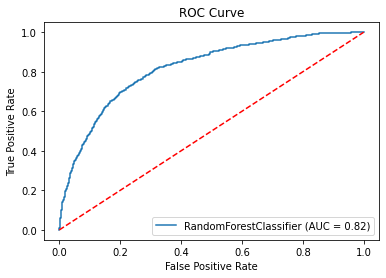

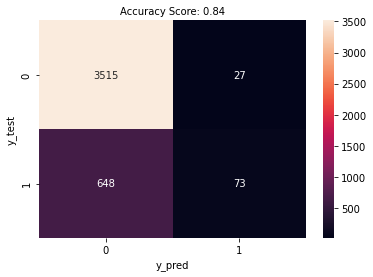

In [49]:
rf_tuned = RandomForest(X, y, X_train, y_train, X_test, y_test,roc_curve=True)

In [50]:
############################################################################################################
#GBM
############################################################################################################
def GradientBoosting(X, y, X_train, y_train, X_test, y_test,skf = StratifiedKFold(n_splits=10),scoring="roc_auc",roc_curve=False,random_state=45):
    print('#########################  GBM   ##############################')
    gbm_params = {"learning_rate": 0.02, 'max_depth': 6,
                   'max_features': 24,
                   'min_samples_leaf': 2,
                   'min_samples_split': 2,
                   'n_estimators': 1500,
                   'subsample': 0.7,
                   'verbose': False}
    gbm_tuned = GradientBoostingClassifier(**gbm_params, random_state=random_state).fit(X_train, y_train)
    # cross_validate
    tuned_cv_results = cross_validate(gbm_tuned, X, y, cv=10, scoring=scoring,n_jobs=-1)
    print('KFold cross validate')
    print(f"roc_auc_mean :{tuned_cv_results['test_score'].mean()}")
    # cross_val_score
    cv_results = cross_val_score(gbm_tuned, X_test, y_test, cv=skf.split(X_test, y_test), scoring=scoring,n_jobs=-1)
    print('Stratifield Nfold cross val score')
    print(f"roc_auc_mean:{cv_results.mean()}")
    # ROC Curve
    if roc_curve:
        plot_roc_curve(gbm_tuned, X_test, y_test)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.show()
    # plot_confusion_matrix
    y_pred = gbm_tuned.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return gbm_tuned

#The cross_validate function differs from cross_val_score in two ways -
#It allows specifying multiple metrics for evaluation.
#It returns a dict containing training scores, fit-times and score-times in addition to the test score.

#########################  GBM   ##############################
KFold cross validate
roc_auc_mean :0.782946462418505
Stratifield Nfold cross val score
roc_auc_mean:0.817524903957709


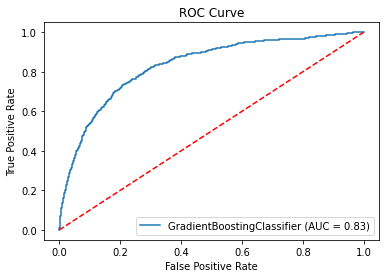

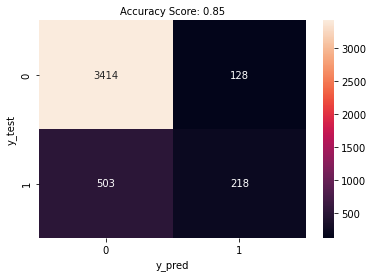

In [51]:
gbm_tuned=GradientBoosting(X, y, X_train, y_train, X_test, y_test,roc_curve=True)

In [52]:
############################################################################################################
# XGBoost
############################################################################################################
def XGBoost(X, y, X_train, y_train, X_test, y_test,skf = StratifiedKFold(n_splits=5),scoring="roc_auc",roc_curve=False,random_state=45):
    print('#########################  XGBOOST   ##############################')
    xgb_params = {'objective': 'binary:logistic',
                  'eval_metric': "auc",
                  'seed': 1,'max_depth': 5,
                  'eta':0.01,
                  'gamma':0.01,
                  'min_child_weight': 0.2,
                  'max_delta_step': 10,
                  'subsample':0.8,
                  'colsample_bytree':0.5,
                  'sampling_method':'uniform'}
    # auc train and test
    df_train = xgb.DMatrix(X_train, y_train)
    df_test = xgb.DMatrix(X_test, y_test)
    watchlist = [(df_train, 'train'), (df_test, 'valid')]
    num_round=6800
    xgb_base_model = xgb.train(xgb_params, df_train,
                           num_round,watchlist,
                           verbose_eval=200,early_stopping_rounds=200)

    #K-fold Cross validation
    df_xgb=xgb.DMatrix(X,y)
    xgb_cv = xgb.cv(xgb_params, df_xgb,
                num_boost_round=10000,
                early_stopping_rounds=200, nfold=10,
                verbose_eval=500)
    print('KFold cross validate')
    print(f"roc_auc_mean :{np.mean(xgb_cv)}")
    #Cross_val_score
    xgb_tuned = xgb.XGBClassifier(**xgb_params,n_estimators=1000,use_label_encoder=False)
    xgb_tuned.fit(X_train,y_train)
    cv_results = cross_val_score(xgb_tuned, X_test, y_test, cv=skf.split(X_test, y_test),n_jobs=-1, scoring='roc_auc')
    print('Stratifield Nfold cross val score')
    print(f"roc_auc_mean:{cv_results.mean()}")
    # ROC Curve
    if roc_curve:
        plot_roc_curve(xgb_tuned, X_test, y_test)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.show()
    # plot_confusion_matrix
    y_pred = xgb_tuned.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return xgb_tuned

#########################  XGBOOST   ##############################
[0]	train-auc:0.75387	valid-auc:0.70761
[200]	train-auc:0.89264	valid-auc:0.79456
[400]	train-auc:0.93086	valid-auc:0.80400
[600]	train-auc:0.95624	valid-auc:0.81062
[800]	train-auc:0.97296	valid-auc:0.81514
[1000]	train-auc:0.98367	valid-auc:0.81816
[1200]	train-auc:0.99023	valid-auc:0.82047
[1400]	train-auc:0.99429	valid-auc:0.82177
[1600]	train-auc:0.99676	valid-auc:0.82278
[1800]	train-auc:0.99821	valid-auc:0.82302
[2000]	train-auc:0.99911	valid-auc:0.82390
[2200]	train-auc:0.99958	valid-auc:0.82451
[2400]	train-auc:0.99981	valid-auc:0.82465
[2600]	train-auc:0.99993	valid-auc:0.82476
[2800]	train-auc:0.99997	valid-auc:0.82519
[3000]	train-auc:0.99999	valid-auc:0.82589
[3165]	train-auc:1.00000	valid-auc:0.82590
[0]	train-auc:0.75820+0.00396	test-auc:0.72371+0.02277
[500]	train-auc:0.91438+0.00123	test-auc:0.82565+0.01167
[1000]	train-auc:0.95651+0.00130	test-auc:0.83967+0.01105
[1500]	train-auc:0.97833+0.00102	test-

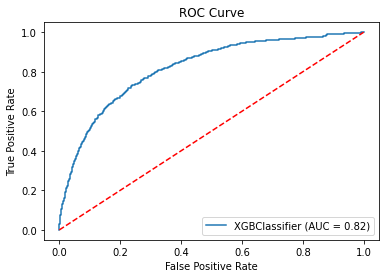

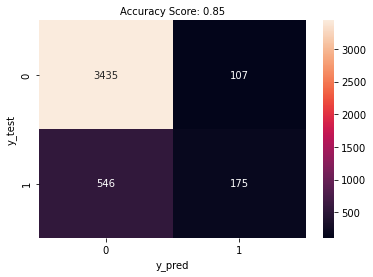

In [53]:
xgb_tuned = XGBoost(X, y, X_train, y_train, X_test, y_test,roc_curve=True)

In [54]:
############################################################################################################
# LightGBM
############################################################################################################
def LightGBM(X, y, X_train, y_train, X_test, y_test,skf = StratifiedKFold(n_splits=10),scoring="roc_auc",roc_curve=False,random_state=45):
    print('#########################  LIGHTGBM   ##############################')
    lgb_params = {'objective': 'binary',
                  'metric': "AUC", 'seed': 1,
                  'num_iterations': 1200,
                  'boosting': 'gbdt',
                  "learning_rate": 0.03,
                  'bagging_fraction': 0.7,
                  "max_depth": 11,
                  'num_leaves': 15,
                  'bagging_freq': 3,
                  'min_data_in_leaf': 2,
                  'max_bin': 34,
                  'feature_fraction': 0.7
                  }
    # auc train and test
    df_train = lgb.Dataset(X_train, y_train)
    df_test = lgb.Dataset(X_test, y_test, reference=df_train)
    lgb.train(lgb_params, df_train,
              valid_sets=[df_train, df_test],
              verbose_eval=100)

    #K-fold Cross validation
    df_lgb = lgb.Dataset(X, y)
    lgb_cv = lgb.cv(lgb_params, df_lgb, nfold=10, verbose_eval=False)


    #Cross_val_score
    lgb_tuned = lgb.LGBMClassifier(**lgb_params, verbose=-1).fit(X_train, y_train)
    cv_results = cross_val_score(lgb_tuned, X_test, y_test, cv=skf.split(X_test, y_test),n_jobs=-1, scoring='roc_auc',verbose=-100)
    print('KFold cross validate')
    print(f"roc_auc_mean :{np.mean(lgb_cv['auc-mean'])}")
    print('Stratifield Nfold cross val score')
    print(f"roc_auc_mean:{cv_results.mean()}")
    # ROC Curve
    if roc_curve:
        plot_roc_curve(lgb_tuned, X_test, y_test)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.show()
    # plot_confusion_matrix
    y_pred = lgb_tuned.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return lgb_tuned

#########################  LIGHTGBM   ##############################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 721, number of negative: 3542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 80
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169130 -> initscore=-1.591808
[LightGBM] [Info] Start training from score -1.591808
[100]	training's auc: 0.901373	valid_1's auc: 0.802497
[200]	training's auc: 0.948952	valid_1's auc: 0.813311
[300]	training's auc: 0.974299	valid_1's auc: 0.818515
[400]	training's auc: 0.986237	valid_1's auc: 0.822242
[500]	training's auc: 0.992886	valid_1's auc: 0.823423
[600

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished


KFold cross validate
roc_auc_mean :0.8399374672786619
Stratifield Nfold cross val score
roc_auc_mean:0.8201049096780373


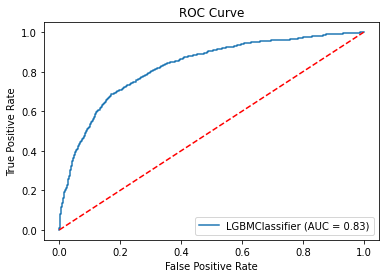

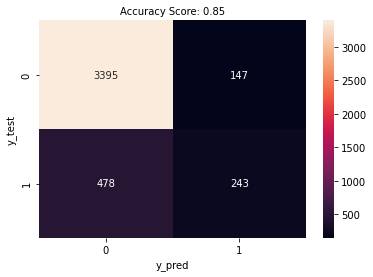

In [55]:
lgb_tuned = LightGBM(X, y, X_train, y_train, X_test, y_test,roc_curve=True)

In [56]:
############################################################################################################
# CatBoostClassifier
############################################################################################################

def CatBoost(X, y, X_train, y_train, X_test, y_test,skf = StratifiedKFold(n_splits=10),scoring="roc_auc",random_state=45,roc_curve=False):
    print('#########################  CATBOOST   ##############################')
    catboost_params = {"iterations": 2500,
                       "learning_rate": 0.01,
                        "depth": 7}
    catboost_tuned = CatBoostClassifier(**catboost_params, random_state=1, verbose=False).fit(X_train,y_train)
    # cross_validate
    tuned_cv_results = cross_validate(catboost_tuned, X, y, cv=10, scoring=scoring,n_jobs=-1)
    print('KFold cross validate')
    print(f"roc_auc_mean :{tuned_cv_results['test_score'].mean()}")
    # cross_val_score
    cv_results = cross_val_score(catboost_tuned, X_test, y_test, cv=skf.split(X_test, y_test), scoring=scoring,n_jobs=-1)
    print('Stratifield Nfold cross val score')
    print(f"roc_auc_mean:{cv_results.mean()}")
    # ROC Curve
    if roc_curve:
        plot_roc_curve(catboost_tuned, X_test, y_test)
        plt.title('ROC Curve')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.show()
    # plot_confusion_matrix
    y_pred = catboost_tuned.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y_test')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()
    return catboost_tuned

#########################  CATBOOST   ##############################
KFold cross validate
roc_auc_mean :0.7937134554249077
Stratifield Nfold cross val score
roc_auc_mean:0.8208456478450543


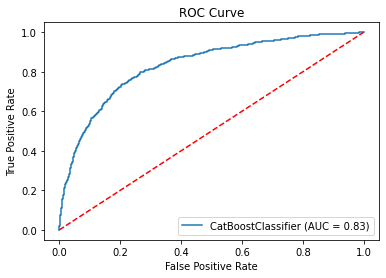

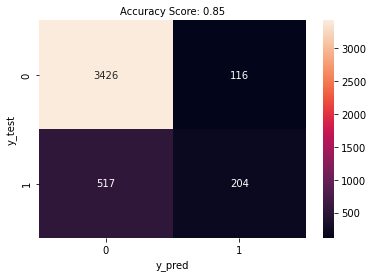

In [57]:
catboost_tuned= CatBoost(X, y, X_train, y_train, X_test, y_test,roc_curve=True)

In [58]:
############################################################################################################
# Stacking & Ensemble Learning
############################################################################################################

def voting(lgb_tuned,xgb_tuned,X_train, y_train, X_test, y_test):
    print("#####################   STACKING & ENSEMBLE LEARNING   ##############################")
    voting_clf = VotingClassifier(estimators=[('LGB', lgb_tuned),('XGB', xgb_tuned)], voting='soft',verbose=False)
    voting_clf.fit(X_train, y_train)
    cv_results = cross_validate(voting_clf, X_test, y_test, cv=10, scoring="roc_auc")
    print(f"voting_auc_mean:{cv_results['test_score'].mean()}")

In [59]:
voting(lgb_tuned,xgb_tuned,X_train, y_train, X_test, y_test)

#####################   STACKING & ENSEMBLE LEARNING   ##############################
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_f

# **FEATURE SELECTION**

In [60]:
ohe1_df=ohe_df

In [61]:
#########################################
# KORELASYON INCELEMESI VE YUKSEK KORELASYONLULARIN CIKARILMASI
def correlationmatrix(dataframe):
    f, ax = plt.subplots(figsize=[25, 20])
    sns.heatmap(dataframe.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
    ax.set_title("Correlation Matrix", fontsize=20)
    plt.show()
    #korelasyon matris ciktisi
    dataframe.columns
    high_corr = dataframe.corr()
    for i in high_corr.columns:
        print(high_corr[i].sort_values(ascending=False)[1:6])
        print('##################################################')

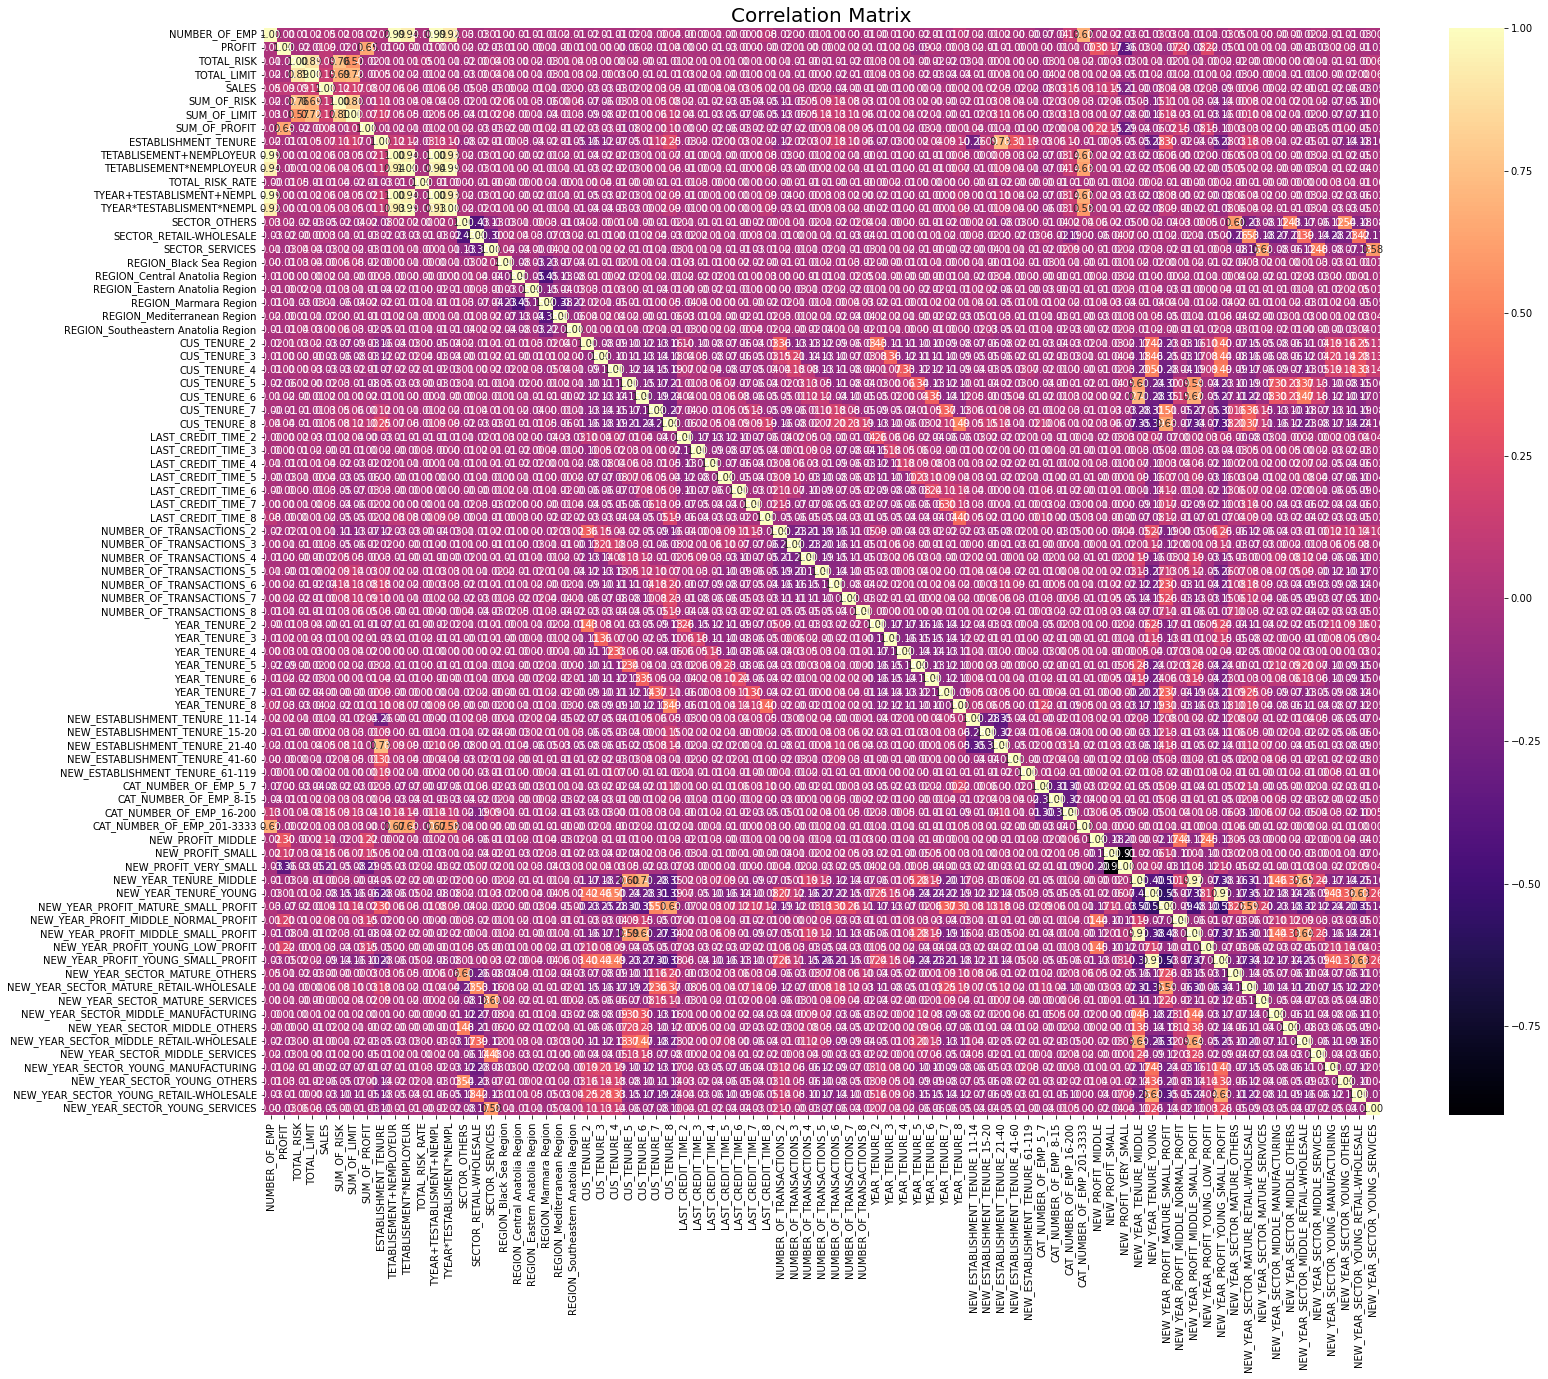

TETABLISEMENT+NEMPLOYEUR     0.995
TYEAR+TESTABLISMENT+NEMPL    0.993
TETABLISEMENT*NEMPLOYEUR     0.938
TYEAR*TESTABLISMENT*NEMPL    0.923
CAT_NUMBER_OF_EMP_201-3333   0.674
Name: NUMBER_OF_EMP, dtype: float64
##################################################
SUM_OF_PROFIT                          0.647
NEW_PROFIT_MIDDLE                      0.302
NEW_YEAR_PROFIT_YOUNG_LOW_PROFIT       0.221
NEW_YEAR_PROFIT_MIDDLE_NORMAL_PROFIT   0.205
NEW_PROFIT_SMALL                       0.172
Name: PROFIT, dtype: float64
##################################################
TOTAL_LIMIT                      0.890
SUM_OF_RISK                      0.760
SUM_OF_LIMIT                     0.573
SALES                            0.094
NEW_YEAR_SECTOR_YOUNG_SERVICES   0.064
Name: TOTAL_RISK, dtype: float64
##################################################
TOTAL_RISK                 0.890
SUM_OF_LIMIT               0.724
SUM_OF_RISK                0.687
SALES                      0.146
CAT_NUMBER_OF_EMP_16-2

In [62]:
correlationmatrix(ohe1_df)

In [63]:

###### AVERAGE OF FEATURE IMPORTANCES ACCORDING TO TREE BASED SELECTION METHOD ###################
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(14, 14))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(f"{model}_feature_importances.png")

    return feature_imp.sort_values(by="Value", ascending=False)

def average_feature_importance():
    df_xgb=plot_importance(xgb_tuned,X)
    df_lgb = plot_importance(lgb_tuned, X)
    df_catboost = plot_importance(catboost_tuned, X)
    df_gbm = plot_importance(gbm_tuned, X)
    df_rf=plot_importance(rf_tuned,X)

    # We scale between 0 and 1 to bring the resulting value values to the same level.
    scaler = MinMaxScaler((0, 1))
    df_lgb['Value'] = scaler.fit_transform(df_lgb[['Value']])
    df_gbm['Value'] = scaler.fit_transform(df_gbm[['Value']])
    df_catboost['Value'] = scaler.fit_transform(df_catboost[['Value']])
    df_rf['Value']=scaler.fit_transform(df_rf[['Value']])
    df_xgb['Value']=scaler.fit_transform(df_xgb[['Value']])
    # model adlarinida df lere colon olarak ekleyelim.
    df_lgb['model_name'] = 'lgb'
    df_gbm['model_name'] = 'gbm'
    df_catboost['model_name'] = 'catboost'
    df_rf['model_name']='rf'
    df_xgb['model_name']='xgb'

    # Let's concat the feature importances created according to 5 models and create a df.
    df_importance = pd.concat([df_lgb, df_gbm, df_catboost,df_rf,df_xgb])
    # We make the name of the column named value feature importance.
    df_importance['feature_importance'] = df_importance['Value']
    df_importance = df_importance.drop('Value', axis=1)
    # Let's take groupby and find the average of feature importance according to features.
    df_importance_final = df_importance.groupby('Feature').agg({'feature_importance': 'mean'}).sort_values(
        'feature_importance',ascending=False)
    return df_importance_final


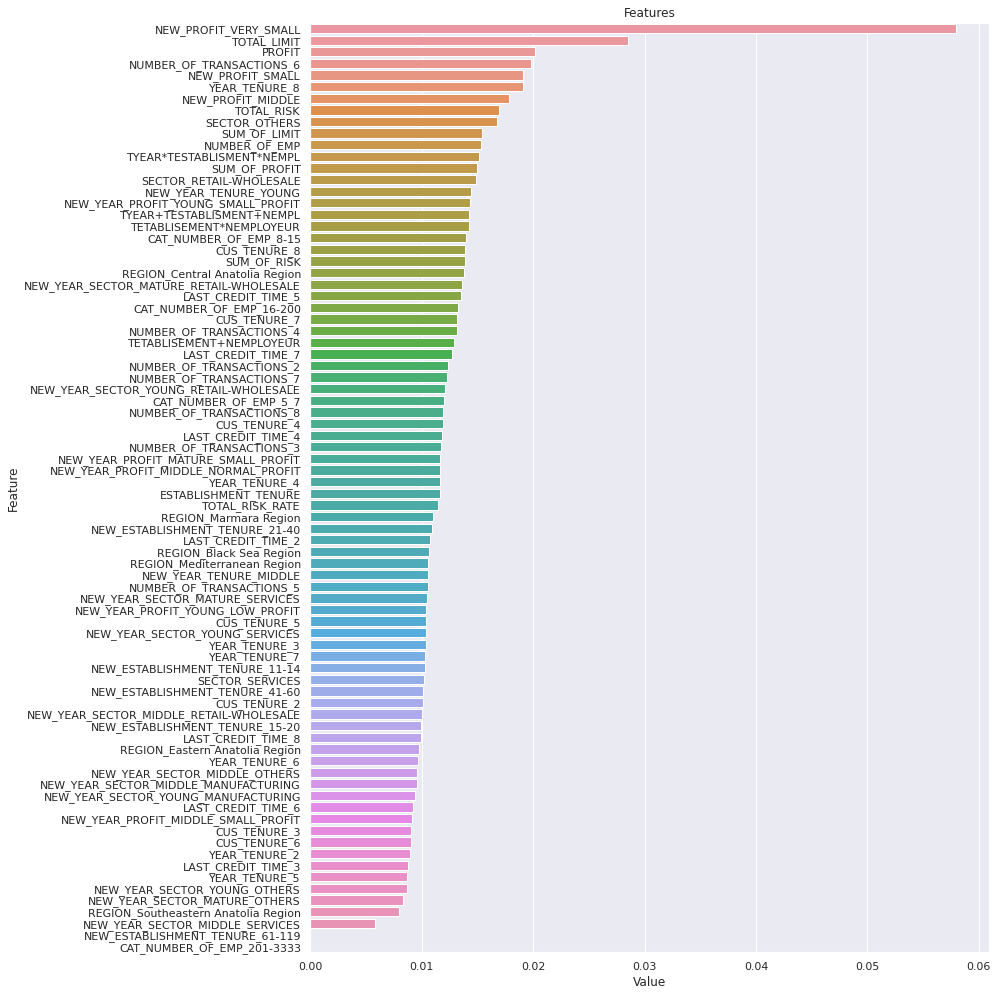

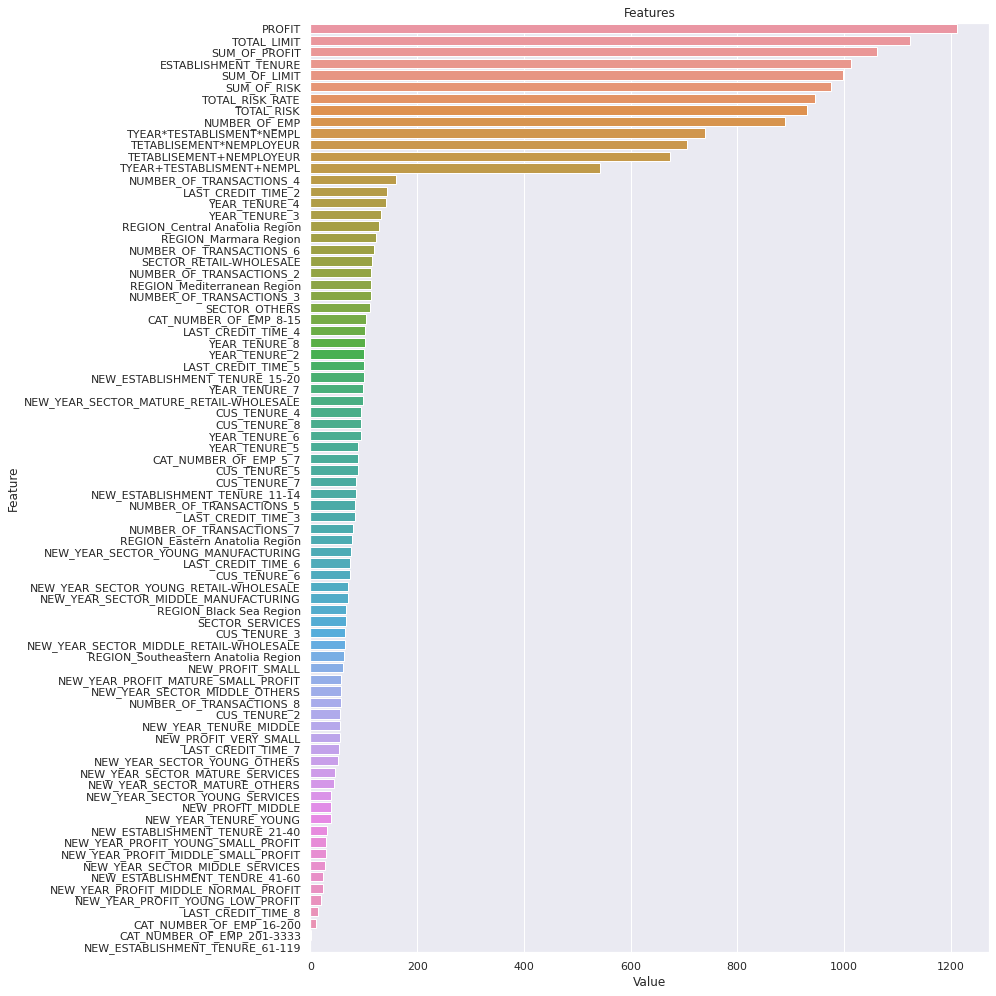

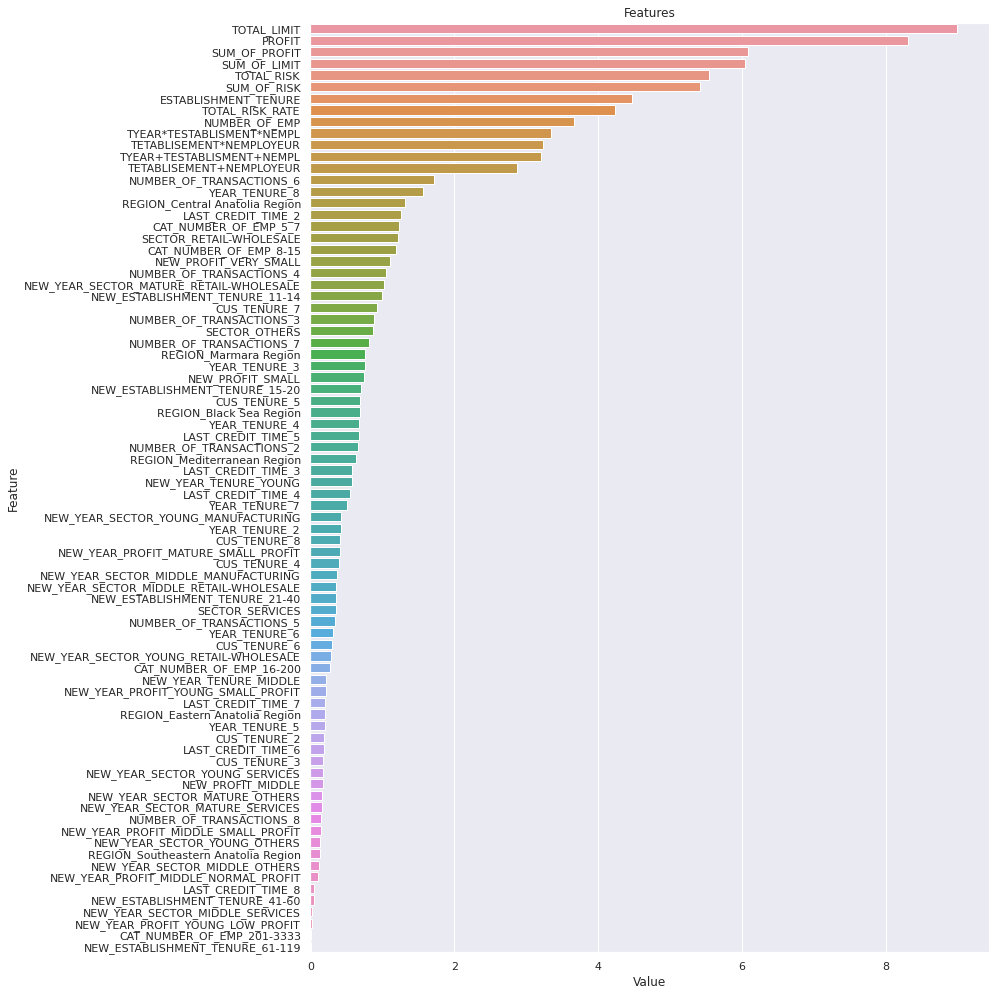

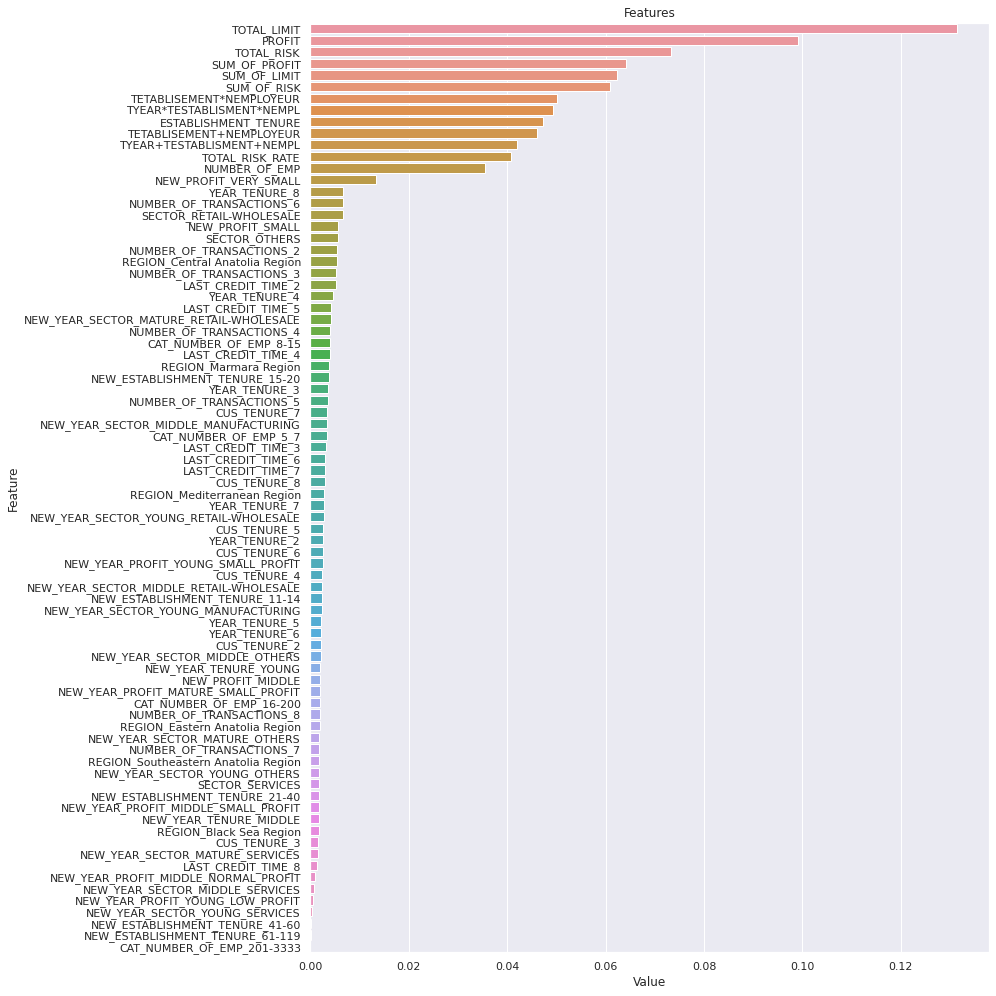

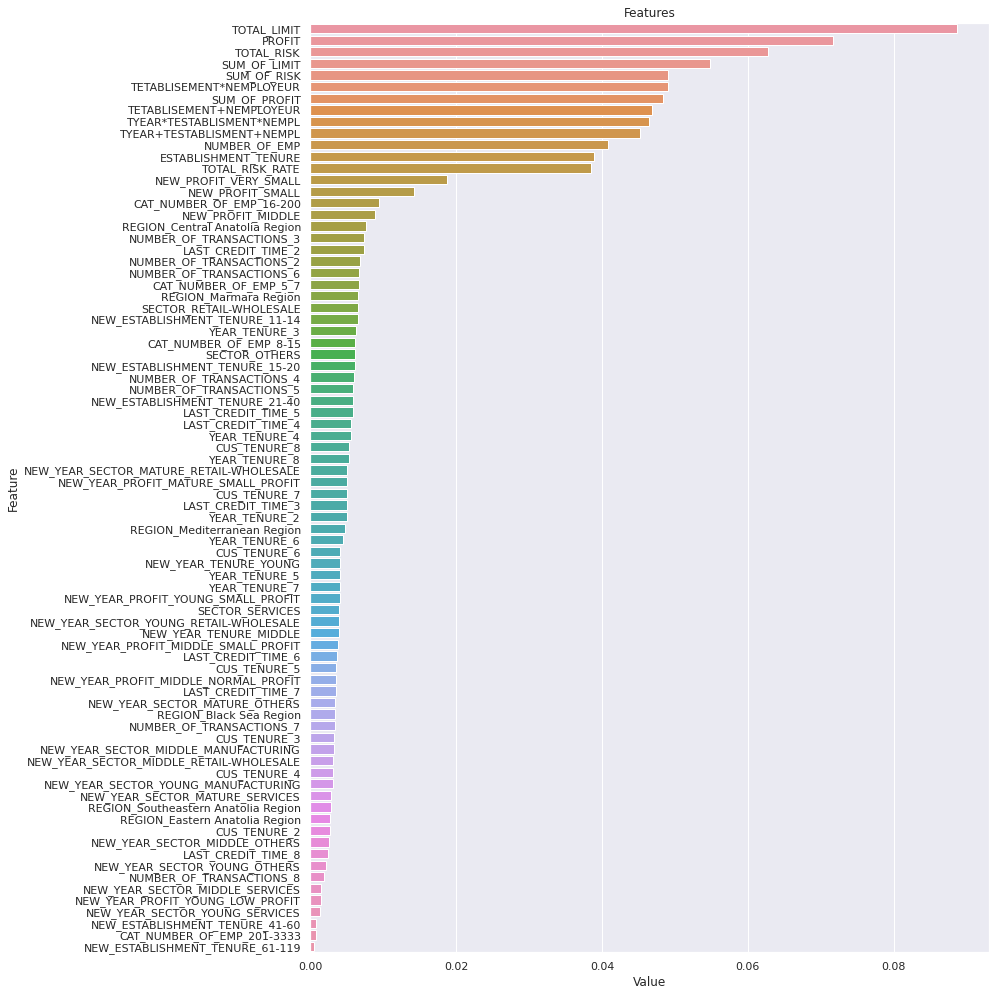

In [64]:
df_importance_final=average_feature_importance()


In [65]:
pd.set_option('display.max_rows', None)
df_importance_final

,feature_importance
Feature,
TOTAL_LIMIT,0.884
PROFIT,0.767
TOTAL_RISK,0.588
SUM_OF_LIMIT,0.571
SUM_OF_PROFIT,0.569
SUM_OF_RISK,0.532
ESTABLISHMENT_TENURE,0.466
TOTAL_RISK_RATE,0.438
TYEAR*TESTABLISMENT*NEMPL,0.428


In [66]:
def drop(dataframe):
    # Extracting highly correlated important features by looking at correlation and feature importance
    print("###################   FEATURE SELECTION    ##############################")
    print("Some features were eliminated by looking at the high correlations and the average of their feature importance.")
    ohe1_df = dataframe.drop(['NEW_YEAR_TENURE_YOUNG',
                          'NEW_YEAR_PROFIT_MIDDLE_SMALL_PROFIT',
                          'NEW_ESTABLISHMENT_TENURE_21-40',
                          'SUM_OF_RISK', 'TOTAL_LIMIT',
                          'TYEAR+TESTABLISMENT+NEMPL',
                          'TETABLISEMENT+NEMPLOYEUR',
                          'NEW_ESTABLISHMENT_TENURE_61-119',
                          'NEW_YEAR_SECTOR_MIDDLE_SERVICES','PROFIT',
                          'NUMBER_OF_EMP','NEW_ESTABLISHMENT_TENURE_41-60',
                          'NEW_YEAR_PROFIT_YOUNG_LOW_PROFIT', 'NEW_YEAR_SECTOR_YOUNG_SERVICES',
                          'CUS_TENURE_3','CAT_NUMBER_OF_EMP_201-3333','CUS_TENURE_2',
                          'NEW_YEAR_SECTOR_MATURE_OTHERS',
                          'NUMBER_OF_TRANSACTIONS_8',
                          'YEAR_TENURE_7', 'LAST_CREDIT_TIME_8',
                          'YEAR_TENURE_2','YEAR_TENURE_6', 'YEAR_TENURE_5',
                          'NEW_YEAR_SECTOR_YOUNG_MANUFACTURING','YEAR_TENURE_3',
                          'NEW_YEAR_SECTOR_MIDDLE_OTHERS',
                          'CUS_TENURE_5',
                          'NEW_YEAR_SECTOR_YOUNG_RETAIL-WHOLESALE',
                          'NEW_YEAR_SECTOR_MIDDLE_MANUFACTURING',
                          'NUMBER_OF_TRANSACTIONS_7',
                          'NEW_YEAR_PROFIT_MIDDLE_NORMAL_PROFIT',
                          'CAT_NUMBER_OF_EMP_16-200',
                          'LAST_CREDIT_TIME_3','YEAR_TENURE_4',
                          'LAST_CREDIT_TIME_6',
                          'NEW_YEAR_TENURE_MIDDLE',
                          'NEW_YEAR_PROFIT_YOUNG_SMALL_PROFIT',
                          'NUMBER_OF_TRANSACTIONS_5',
                          'NEW_YEAR_PROFIT_MATURE_SMALL_PROFIT',
                          'CUS_TENURE_4',
                          'NEW_PROFIT_MIDDLE',
                          'CAT_NUMBER_OF_EMP_8-15',
                          'NEW_YEAR_SECTOR_MATURE_SERVICES',
                          'SECTOR_SERVICES',
                          'NEW_YEAR_SECTOR_YOUNG_OTHERS',
                          'CUS_TENURE_6',
                          'NEW_ESTABLISHMENT_TENURE_11-14',
                          'LAST_CREDIT_TIME_7',
                          'NEW_ESTABLISHMENT_TENURE_15-20'], axis=1)
    return ohe1_df

In [67]:
ohe1_df=drop(ohe1_df)

###################   FEATURE SELECTION    ##############################
Some features were eliminated by looking at the high correlations and the average of their feature importance.


# **MODELLING 2**

In [68]:
# Let's set up final models again according to all models by subtracting the correlated values.

######################################
# MODELLING 2
def model_prep1(dataframe,test_size=0.50):
    y1 = dataframe['SALES']
    X1 = dataframe.drop(['SALES'], axis=1)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=45,stratify=y1)
    return dataframe,X1,y1,X1_train,y1_train,X1_test,y1_test

In [69]:
ohe1_df,X1,y1,X1_train,y1_train,X1_test,y1_test=model_prep1(ohe1_df)
check_df(ohe1_df)

##################### Shape #####################
(8526, 31)
##################### Types #####################
TOTAL_RISK                                 float64
SALES                                        int64
SUM_OF_LIMIT                               float64
SUM_OF_PROFIT                              float64
ESTABLISHMENT_TENURE                       float64
TETABLISEMENT*NEMPLOYEUR                   float64
TOTAL_RISK_RATE                            float64
TYEAR*TESTABLISMENT*NEMPL                  float64
SECTOR_OTHERS                                uint8
SECTOR_RETAIL-WHOLESALE                      uint8
REGION_Black Sea Region                      uint8
REGION_Central Anatolia Region               uint8
REGION_Eastern Anatolia Region               uint8
REGION_Marmara Region                        uint8
REGION_Mediterranean Region                  uint8
REGION_Southeastern Anatolia Region          uint8
CUS_TENURE_7                                 uint8
CUS_TENURE_8          

In [70]:
######################################################
# Base Models gore(feature selection yapilarak)
######################################################
base_models(X1, y1, X1_train, y1_train, X1_test, y1_test)

[19:06:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc: 0.7145 (KNN) 
roc_auc: 0.7362 (SVC) 
roc_auc: 0.6088 (CART) 
roc_auc: 0.799 (RF) 
roc_auc: 0.7723 (Adaboost) 
roc_auc: 0.7891 (GBM) 
roc_auc: 0.7925 (LightGBM) 
roc_auc: 0.8055 (CatBoost) 
[19:07:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:07:36] WARNING: ../src/learner.cc:1115: St

#########################  RF   ##############################
KFold cross validate
roc_auc_mean :0.7727972309109424
Stratifield Kfold cross val score
roc_auc_mean:0.80613070259997


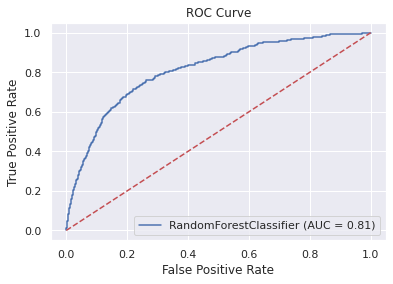

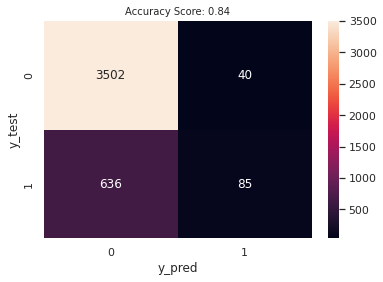

RandomForestClassifier(max_depth=19, max_features=3, min_samples_split=10,
                       n_estimators=240, random_state=45)

In [71]:
############################################################################################################
# Random Forests
############################################################################################################
RandomForest(X1, y1, X1_train, y1_train, X1_test, y1_test,roc_curve=True)

#########################  GBM   ##############################
KFold cross validate
roc_auc_mean :0.7702126296930881
Stratifield Nfold cross val score
roc_auc_mean:0.8084834636424866


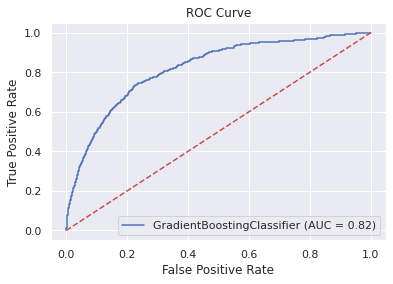

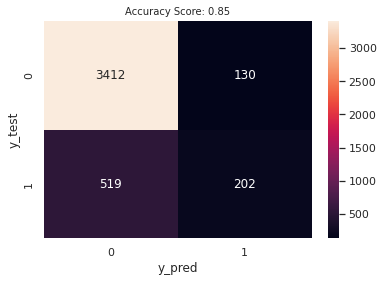

GradientBoostingClassifier(learning_rate=0.02, max_depth=6, max_features=24,
                           min_samples_leaf=2, n_estimators=1500,
                           random_state=45, subsample=0.7, verbose=False)

In [72]:
############################################################################################################
#GBM
############################################################################################################
GradientBoosting(X1, y1, X1_train, y1_train, X1_test, y1_test,roc_curve=True)

#########################  XGBOOST   ##############################
[0]	train-auc:0.67556	valid-auc:0.64195
[200]	train-auc:0.88232	valid-auc:0.78138
[400]	train-auc:0.91803	valid-auc:0.78925
[600]	train-auc:0.94403	valid-auc:0.79708
[800]	train-auc:0.96242	valid-auc:0.80194
[1000]	train-auc:0.97516	valid-auc:0.80567
[1200]	train-auc:0.98285	valid-auc:0.80760
[1400]	train-auc:0.98818	valid-auc:0.80914
[1600]	train-auc:0.99222	valid-auc:0.81026
[1800]	train-auc:0.99495	valid-auc:0.81071
[2000]	train-auc:0.99680	valid-auc:0.81110
[2139]	train-auc:0.99763	valid-auc:0.81098
[0]	train-auc:0.67246+0.00553	test-auc:0.64309+0.03083
[500]	train-auc:0.90199+0.00145	test-auc:0.81175+0.01532
[1000]	train-auc:0.94774+0.00114	test-auc:0.82834+0.01526
[1500]	train-auc:0.97037+0.00087	test-auc:0.83602+0.01508
[2000]	train-auc:0.98284+0.00067	test-auc:0.83974+0.01479
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[2500]	train-auc:0.99020+0.00044	test-auc:0.84195+0.01524
[3000]	train-auc:0.99451+0.00031	test-auc:0.84349+0.01516
[3500]	train-auc:0.99697+0.00019	test-auc:0.84428+0.01523
[4000]	train-auc:0.99836+0.00012	test-auc:0.84513+0.01525
[4500]	train-auc:0.99915+0.00006	test-auc:0.84527+0.01537
[4592]	train-auc:0.99925+0.00006	test-auc:0.84534+0.01528
KFold cross validate
roc_auc_mean :train-auc-mean   0.966
train-auc-std    0.001
test-auc-mean    0.834
test-auc-std     0.015
dtype: float64
Stratifield Nfold cross val score
roc_auc_mean:0.7998532891448542


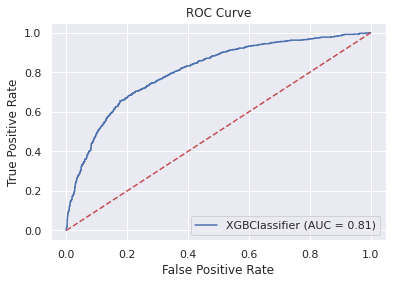

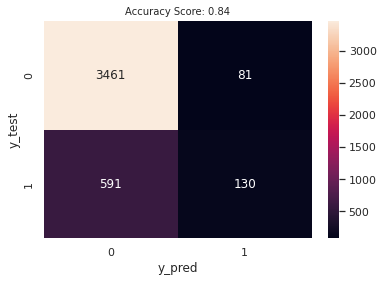

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eta=0.01, eval_metric='auc', gamma=0.01,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=10, max_depth=5,
              min_child_weight=0.2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=1, reg_alpha=0, reg_lambda=1,
              sampling_method='uniform', scale_pos_weight=1, seed=1,
              subsample=0.8, tree_method='exact', ...)

In [73]:
############################################################################################################
# XGBoost
############################################################################################################
XGBoost(X1, y1, X1_train, y1_train, X1_test, y1_test,roc_curve=True)

#########################  LIGHTGBM   ##############################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 721, number of negative: 3542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169130 -> initscore=-1.591808
[LightGBM] [Info] Start training from score -1.591808
[100]	training's auc: 0.882322	valid_1's auc: 0.786083
[200]	training's auc: 0.930845	valid_1's auc: 0.794877
[300]	training's auc: 0.959838	valid_1's auc: 0.801896
[400]	training's auc: 0.975526	valid_1's auc: 0.80

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


KFold cross validate
roc_auc_mean :0.8265119179764516
Stratifield Nfold cross val score
roc_auc_mean:0.8018357453365033


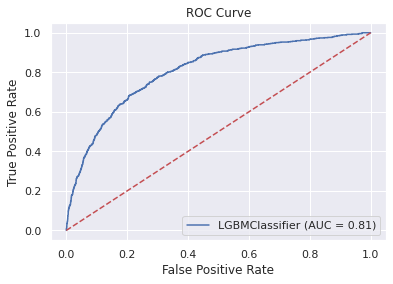

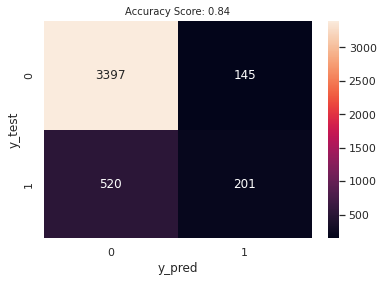

LGBMClassifier(bagging_fraction=0.7, bagging_freq=3, boosting='gbdt',
               feature_fraction=0.7, learning_rate=0.03, max_bin=34,
               max_depth=11, metric='AUC', min_data_in_leaf=2,
               num_iterations=1200, num_leaves=15, objective='binary', seed=1,
               verbose=-1)

In [74]:
############################################################################################################
# LightGBM
############################################################################################################
LightGBM(X1, y1, X1_train, y1_train, X1_test, y1_test,roc_curve=True)

#########################  CATBOOST   ##############################
KFold cross validate
roc_auc_mean :0.7782215479695973
Stratifield Nfold cross val score
roc_auc_mean:0.8061088288236242


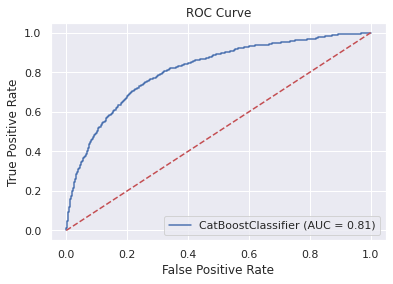

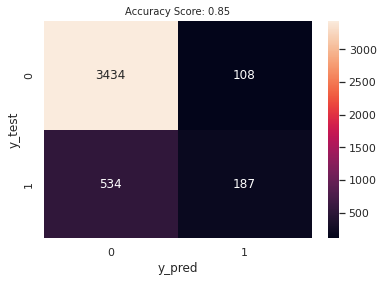

In [75]:
############################################################################################################
# CatBoostClassifier
############################################################################################################
CatBoost(X1, y1, X1_train, y1_train, X1_test, y1_test,roc_curve=True)

# **FINAL MODEL**
**note: We choose xgboost as the final model, since the values obtained as a result of the feature selection are less than the original ones.**

# **PIPELINE**

In [76]:
############################################################################################################
# PIPELINE
############################################################################################################

def pipeline_prediction_sales():
    # Let's combine all the operations we have done in a custom pipeline.
    print("1")
    df = pd.read_csv("../input/final2/Final_Project.csv")
    print("2")
    df, df_3 = data_prep(df)
    print("3")
    df = missing_value(df)
    print("4")
    df=feature_engineering(df)
    check_df(df)
    print("5")
    ohe_df = one_hot(df)
    print("6")
    ohe_df = robust_scaler(ohe_df)
    print("7")
    ohe_df,X, y, X_train, y_train, X_test, y_test = model_prep(ohe_df)
    print("8")
    base_models(X, y, X_train, y_train, X_test, y_test)
    print("9")
    print("############ HYPERPARAMETERS OPTIMIZED ############")
    rf_tuned = RandomForest(X, y, X_train, y_train, X_test, y_test,roc_curve=True)
    print("10")
    gbm_tuned = GradientBoosting(X, y, X_train, y_train, X_test, y_test,roc_curve=True)
    print("11")
    xgb_tuned = XGBoost(X, y, X_train, y_train, X_test, y_test,roc_curve=True)
    print("12")
    lgb_tuned = LightGBM(X, y, X_train, y_train, X_test, y_test,roc_curve=True)
    print("13")
    catboost_tuned = CatBoost(X, y, X_train, y_train, X_test, y_test,roc_curve=True)
    print("14")
    voting(lgb_tuned,xgb_tuned,X_train, y_train, X_test, y_test)
    print("15")
    print("##  WE SELECT THE HIGHEST SCORE XGBOOST AS THE FINAL MODEL ##")
    final_model=xgb_tuned

    return X,y,ohe_df,final_model


1
2
##################### Shape #####################
(11357, 13)
##################### Types #####################
YEAR                               int64
Customer_num                      object
Establishment_Date        datetime64[ns]
Number_of_Emp                    float64
Profit                           float64
Sector                            object
Region                            object
Total_Risk                       float64
Total_Limit                      float64
Sales                              int64
cus_tenure                         int64
last_credit_time                   int64
number_of_transactions             int64
dtype: object
##################### Head #####################
   YEAR Customer_num Establishment_Date  Number_of_Emp     Profit            Sector                        Region  Total_Risk  Total_Limit  Sales  cus_tenure  \
0  2017  RATI9590GZD         2001-01-26          8.000        NaN  RETAIL-WHOLESALE                Marmara Region   70917.000  

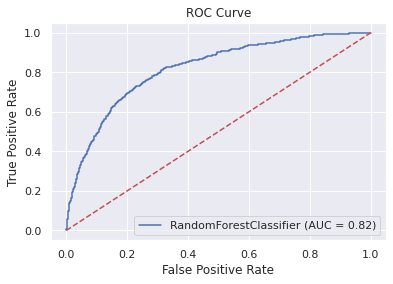

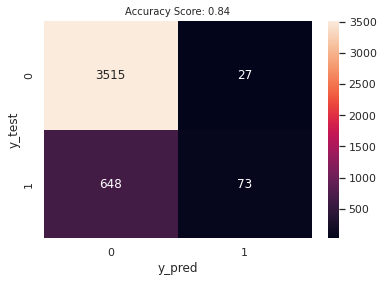

10
#########################  GBM   ##############################
KFold cross validate
roc_auc_mean :0.782946462418505
Stratifield Nfold cross val score
roc_auc_mean:0.817524903957709


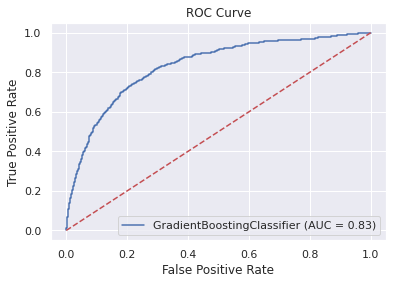

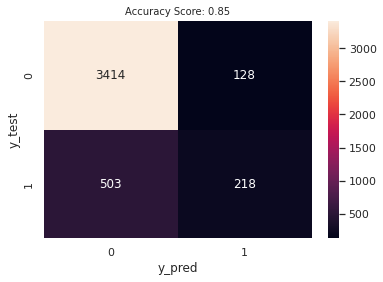

11
#########################  XGBOOST   ##############################
[0]	train-auc:0.75387	valid-auc:0.70761
[200]	train-auc:0.89264	valid-auc:0.79456
[400]	train-auc:0.93086	valid-auc:0.80400
[600]	train-auc:0.95624	valid-auc:0.81062
[800]	train-auc:0.97296	valid-auc:0.81514
[1000]	train-auc:0.98367	valid-auc:0.81816
[1200]	train-auc:0.99023	valid-auc:0.82047
[1400]	train-auc:0.99429	valid-auc:0.82177
[1600]	train-auc:0.99676	valid-auc:0.82278
[1800]	train-auc:0.99821	valid-auc:0.82302
[2000]	train-auc:0.99911	valid-auc:0.82390
[2200]	train-auc:0.99958	valid-auc:0.82451
[2400]	train-auc:0.99981	valid-auc:0.82465
[2600]	train-auc:0.99993	valid-auc:0.82476
[2800]	train-auc:0.99997	valid-auc:0.82519
[3000]	train-auc:0.99999	valid-auc:0.82589
[3165]	train-auc:1.00000	valid-auc:0.82590
[0]	train-auc:0.75820+0.00396	test-auc:0.72371+0.02277
[500]	train-auc:0.91438+0.00123	test-auc:0.82565+0.01167
[1000]	train-auc:0.95651+0.00130	test-auc:0.83967+0.01105
[LightGBM] [Warning] bagging_fracti

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1500]	train-auc:0.97833+0.00102	test-auc:0.84686+0.01176
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warn

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[2000]	train-auc:0.98984+0.00062	test-auc:0.85086+0.01188
[2500]	train-auc:0.99553+0.00044	test-auc:0.85286+0.01175
[3000]	train-auc:0.99817+0.00021	test-auc:0.85439+0.01150
[3500]	train-auc:0.99933+0.00009	test-auc:0.85546+0.01169
[3854]	train-auc:0.99969+0.00005	test-auc:0.85574+0.01173
KFold cross validate
roc_auc_mean :train-auc-mean   0.966
train-auc-std    0.001
test-auc-mean    0.843
test-auc-std     0.012
dtype: float64
Stratifield Nfold cross val score
roc_auc_mean:0.811747076885087


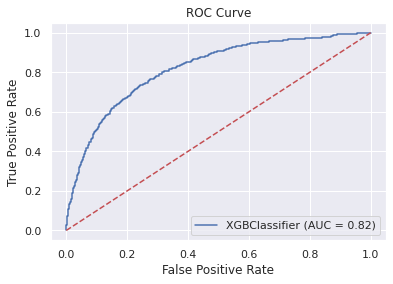

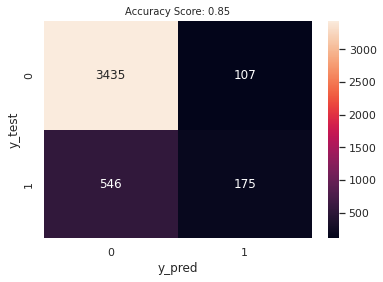

12
#########################  LIGHTGBM   ##############################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 721, number of negative: 3542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 4263, number of used features: 80
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169130 -> initscore=-1.591808
[LightGBM] [Info] Start training from score -1.591808
[100]	training's auc: 0.901373	valid_1's auc: 0.802497
[200]	training's auc: 0.948952	valid_1's auc: 0.813311
[300]	training's auc: 0.974299	valid_1's auc: 0.818515
[400]	training's auc: 0.986237	valid_1's auc: 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished


KFold cross validate
roc_auc_mean :0.8399374672786619
Stratifield Nfold cross val score
roc_auc_mean:0.8201049096780373


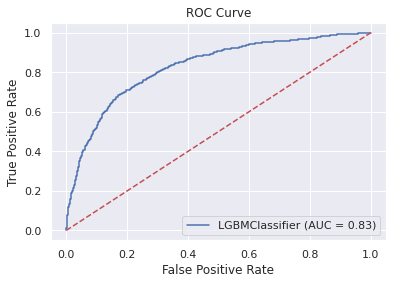

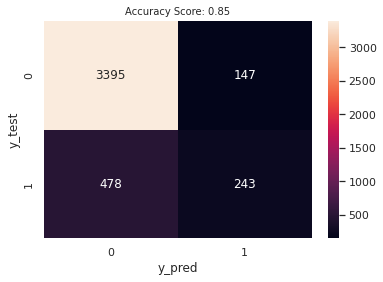

13
#########################  CATBOOST   ##############################
KFold cross validate
roc_auc_mean :0.7937134554249077
Stratifield Nfold cross val score
roc_auc_mean:0.8208456478450543


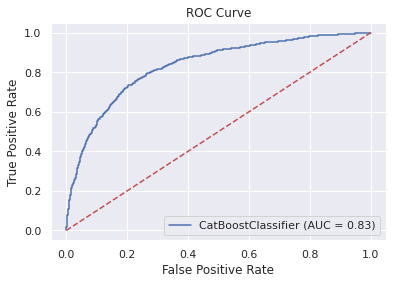

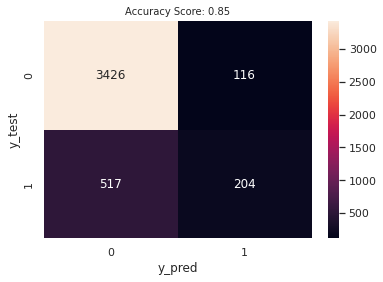

14
#####################   STACKING & ENSEMBLE LEARNING   ##############################
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featur

In [77]:
X,y,ohe_df,final_model= pipeline_prediction_sales()

# **CONVERT TO PICKLE**

In [78]:
###########################################################################################################
# CONVERT TO PICKLE
###########################################################################################################
import os
import joblib
import pickle
os.chdir("./")
joblib.dump(final_model, "final_proje_predict.pkl")
finalmodel = joblib.load("./final_proje_predict.pkl")

# **Prediction for a New Observation**

In [79]:
######################################################
# Prediction for a New Observation
######################################################
random_user = X.sample(1)
finalmodel.predict(random_user)
ohe_df[ohe_df.index==random_user.index[0]]['SALES']

6910    0
Name: SALES, dtype: int64